# NBA ANALYTICS PROJECT

Who are the top undervalued players based on their court position that are currently playing in the NBA? How would they perform if we had such a fictional starting five roster? Using the NBA REST API and web scraping Basketball Reference, we try to assemble an undervalued all-star team composed of just a starting five and predict their winning chances. The idea is based off the book/movie *Moneyball* from Michael Lewis. This project just aims to have fun coding and applying analytics to basketball.


### What This Notebook Shows:

- Use of NBA REST API and web scraping Basketball Reference
- Analyzing and discussing the NBA stats
- Making an undervalued all-star team
- Using machine learning to predict winning chances
- Conclusion, recommendations
- Articles & references related to this project

### Introduction / Important Notes Before Getting Started:

To make this small team, we only use active players from the 2019/2020 season. This normally means __450 players__ (there are 30 teams and 15 players per team). Eventually, there are some players signing in small contracts (Two-Way Contracts) from the G-league, who we will __not consider__ in this project. 

We then have to think about what makes a player successful. The most important aspect in basketball is __winning__ but more importantly in our case, how much a player contributes to the win. After all, what is the point of playing better or winning more than someone else if you are not contributing to winning? For this project, we take a case by case approach as we separate the players based on their positions. We also have to note that every franchise is recording data that is not made public (obviously as it is a competition and every team wants to be the best) and hence we can only use statistics that are made public by the NBA in this project. (The bigger topics for some researchers are how the game is changing and how inefficiently the game is played and analyzed right now.)

There is obviously no certainty to the end result. A model cannot capture everything we see by watching the game, just like the model can observe things we might not by just watching. This project is just to practice data analytics on a topic I am curious about. Sports analysts go to unprecedented levels of data to achieve good teams, which we won't bother because it would take too much time for a small project like this one. To make the best judgment in my opinion, you need to have a sense of the game. Someone who never played basketball at a high level cannot accurately judge the results by just looking at the numbers. The Houston Rockets, who are one of the first teams that tried reasoning with analytics for many years, never won a championship no matter the talent they had. (Of course, analytics can't guarantee you to win championships but it can help your organization take better decisions.) We have Charles Barkley [(click here for video or watch in the next cell)](https://www.youtube.com/watch?time_continue=39&v=NZf9NFaCQHQ&feature=emb_title) talking about Daryl Morey's analytics. I personally recommend reading "The Undoing Project" by Michael Lewis for those interested in learning more about the analytical mindset. Every front office has biases when making decisions, whether you have or do not have a mathematical model. These "Experts" of the field each have their own minds, which is why everyone has a different opinion. Nevertheless, analytics are now a huge part of each NBA team whether trusted or not.


__To start up our project__, we begin the analysis by taking these different available variables into account:
- The salary cost of the player. We want the undervalued/cheap players discussed more in the next paragraph)
- The number of minutes and/or games played this season by the player. We want players that have some experience, not players who barely played any games. This variable will have to be adjusted throughout the analysis due to COVID-19 as the maximum number of games played is 66 instead of 82 this season (May 10th).
- The winning shares of the player and/or the player efficiency rating. We want players who win, assuming that they're a factor to the win. We also want efficient players based on the time they play. These variables will be explored in the analysis.
- The selected variables from the basic & advanced stats based on the players' position(s) in the game (PG, SG, SF, PF and C)

The average salary cap is __120 million for 15 people__, the lowest are the Atlanta Hawks with 103 and highest are the Portland Blazers with 140. Considering we are not making a full team consisting of 15 people, we will have to fix a certain salary cap.

The average salaries for each position are as follows:
- PG) 9.4 mil
- SG) 7.1 mil
- SF) 8 mil
- PF) 6.6 mil
- C) 9.6 mil
- __Total) 40.7 million salary cap__ for our starting five

Of course, some teams pay more for a certain position than another. We will however stick to the average salary as a maximum salary for each of our players based on their distinct position. This means we will not look at center players that cost above 9.6 mil a year for example.

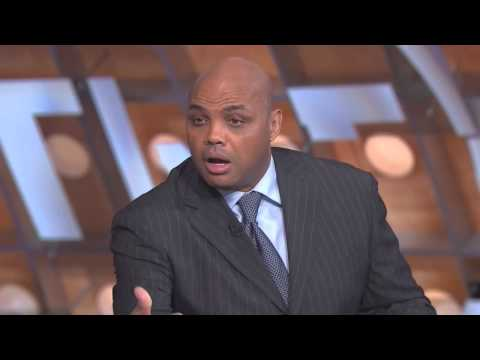

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('NZf9NFaCQHQ', width = 500, height = 300)

###  The NBA REST API & Basketball Reference Data Sources:

Below are the sources used for data:

__NBA REST API Documentation__: https://pypi.org/project/nba-api/

__Basketball Reference Website:__ https://www.basketball-reference.com/

NBA player basic and advanced stats:
- https://www.basketball-reference.com/leagues/NBA_2020_per_game.html
- https://www.basketball-reference.com/leagues/NBA_2020_advanced.html

NBA player salaries:
- https://www.basketball-reference.com/contracts/players.html

In [1]:
# Import libraries
import nba_api
import pandas as pd
import missingno as msno # useful library for visualizing missing values
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen
import scipy.stats as sp
from bs4 import BeautifulSoup


# Machine Learning library
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import export_graphviz # for visualizing models involving trees 

### Explore NBA API:

In [3]:
# Get players dictionary consisting of name, ID and if active or not
from nba_api.stats.static import players
nba_players_dict = players.get_players()

# You can print the dictionary of 4501 players
# print(nba_players_dict)

In [4]:
# Switch dictionary of players into pandas dataframe
nba_players_df = pd.DataFrame(nba_players_dict)

# Check first 10 rows
nba_players_df.head(10)

,first_name,full_name,id,is_active,last_name
0,Alaa,Alaa Abdelnaby,76001,False,Abdelnaby
1,Zaid,Zaid Abdul-Aziz,76002,False,Abdul-Aziz
2,Kareem,Kareem Abdul-Jabbar,76003,False,Abdul-Jabbar
3,Mahmoud,Mahmoud Abdul-Rauf,51,False,Abdul-Rauf
4,Tariq,Tariq Abdul-Wahad,1505,False,Abdul-Wahad
5,Shareef,Shareef Abdur-Rahim,949,False,Abdur-Rahim
6,Tom,Tom Abernethy,76005,False,Abernethy
7,Forest,Forest Able,76006,False,Able
8,John,John Abramovic,76007,False,Abramovic
9,Alex,Alex Abrines,203518,False,Abrines


In [5]:
# Count number of active players in NBA REST API
print(nba_players_df[(nba_players_df.is_active == True)].count())

# Make new dataframe for the active players
active_nba_players_df = nba_players_df[(nba_players_df.is_active == True)]
active_nba_players_df.head()

# This allows us to easily find the ID for each active player

first_name    519
full_name     519
id            519
is_active     519
last_name     519
dtype: int64


,first_name,full_name,id,is_active,last_name
21,Steven,Steven Adams,203500,True,Adams
23,Bam,Bam Adebayo,1628389,True,Adebayo
41,LaMarcus,LaMarcus Aldridge,200746,True,Aldridge
48,Kyle,Kyle Alexander,1629734,True,Alexander
50,Nickeil,Nickeil Alexander-Walker,1629638,True,Alexander-Walker


In [6]:
# Find a player's gamelog to check his stats (in this case Lebron James)
from nba_api.stats.endpoints import playergamelog

lebron = [player for player in nba_players_dict if player['full_name'] == 'LeBron James'][0]
lebron_id = lebron['id']

# Call the API endpoint passing in lebron's ID & which season 
gamelog_lebron = playergamelog.PlayerGameLog(player_id = '2544', season = '2020')

# Convert  gamelog object into a pandas dataframe
# Can also convert to JSON or dictionary  
df_lebron_2020 = gamelog_lebron.get_data_frames()

# If want all seasons, must import the SeasonAll parameter 
from nba_api.stats.library.parameters import SeasonAll

gamelog_lebron_all = playergamelog.PlayerGameLog(player_id = '2544', season = SeasonAll.all)

df_lebron_all = gamelog_lebron_all.get_data_frames()
#df_lebron_all

In [7]:
# Get the NBA teams
from nba_api.stats.static import teams
import matplotlib.pyplot as plt
nba_teams = teams.get_teams()

In [8]:
# Switch dictionary of teams into pandas dataframe
import pandas as pd
nba_teams_df = pd.DataFrame(nba_teams)
nba_teams_df

,abbreviation,city,full_name,id,nickname,state,year_founded
0,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949
1,BOS,Boston,Boston Celtics,1610612738,Celtics,Massachusetts,1946
2,CLE,Cleveland,Cleveland Cavaliers,1610612739,Cavaliers,Ohio,1970
3,NOP,New Orleans,New Orleans Pelicans,1610612740,Pelicans,Louisiana,2002
4,CHI,Chicago,Chicago Bulls,1610612741,Bulls,Illinois,1966
5,DAL,Dallas,Dallas Mavericks,1610612742,Mavericks,Texas,1980
6,DEN,Denver,Denver Nuggets,1610612743,Nuggets,Colorado,1976
7,GSW,Golden State,Golden State Warriors,1610612744,Warriors,California,1946
8,HOU,Houston,Houston Rockets,1610612745,Rockets,Texas,1967
9,LAC,Los Angeles,Los Angeles Clippers,1610612746,Clippers,California,1970


The NBA REST API is nice to use in order to see distinct players stats, how and where they perform better. We will use it again once we have our list of undervalued players by web scraping Basketball Reference in order to predict if our starting five could be successful.

### Scraping Basketball Reference + Cleaning Data Sets:

We now scrape the website *Basketball Reference* to get our players' stats (per game and advanced) and salary data sets in dataframes to analyze and visualize better. This can also be done by just downloading the data from their website onto personal CSVs. Webscraping comes in handy due to the fact that the updated data gets renewed every time we run our script as opposed to redownloading CSV files every time. On the other hand, if the website changes up the formatting, the code might have to be adjusted. We then go through an initial data cleansing before going to the next section involving exploratory data analysis.

In [3]:
# We're analyzing the 2019-2020 NBA season data sets
year = 2020

# First URL page we will scraping
url1 = "https://www.basketball-reference.com/contracts/players.html".format(year)
# this is the HTML from the given URL
html1 = urlopen(url1)
soup1 = BeautifulSoup(html1)

# Second URL page we will scraping
url2 = "https://www.basketball-reference.com/leagues/NBA_2020_per_game.html".format(year)
# this is the HTML from the second given URL
html2 = urlopen(url2)
soup2 = BeautifulSoup(html2)

# Third URL page we will scraping
url3 = "https://www.basketball-reference.com/leagues/NBA_2020_advanced.html".format(year)
# this is the HTML from the third given URL
html3 = urlopen(url3)
soup3 = BeautifulSoup(html3)

In [4]:
# Create for loops to get all the data from each URLs into distinct dataframes

# URL 1: Salaries
all_data = []
elems = soup1.find_all('tr')
for elem in elems:
    player = []
    for a in elem.select('td'):
        try:
            player.append(a.get_text())
        except:
            pass
    all_data.append(player)
df = pd.DataFrame(data = all_data)
df.head()

# Simpler Method 2: Using fewer lines with pandas considering there only is a table on the webpage
#url = "https://www.basketball-reference.com/contracts/players.html"
#test_df = pd.read_html(url)
#df = test_df[0]

# Alternative to Method 1:
# Make it a function and avoid repeating same code for the other 2 dataframes

,0,1,2,3,4,5,6,7,8,9
0,None,None,None,None,None,None,None,None,None,None
1,None,None,None,None,None,None,None,None,None,None
2,Stephen Curry,GSW,"$40,231,758","$43,006,362","$45,780,966",,,,Bird Rights,"$129,019,086"
3,Chris Paul,OKC,"$38,506,482","$41,358,814","$44,211,146",,,,Bird Rights,"$79,865,296"
4,Russell Westbrook,HOU,"$38,178,000","$41,006,000","$43,848,000","$46,662,000",,,Bird Rights,"$123,032,000"


We now have to clean our salary data set using the following steps:
- Delete the columns [3] to [9] as we only need 2019-2020 data
- Rename the column names
- Delete the rows where there are missing data or unneeded lines
- Drop duplicates (take highest contract for each player. Check later if the player is still in NBA or waived)
- Reset the index based on highest to lowest salary

In [5]:
# Drop unneeded columns [3] to [9]
df = df.drop(columns= [3, 4, 5, 6, 7, 8, 9])

# Drop rows
#df = df.drop([ , ], axis=0)

# Rename columns
df.columns = ['Player Name', 'Team', 'Salary']

# Drop missing values
df.dropna(subset=['Player Name', 'Team', 'Salary'], inplace = True)
df.count()

Player Name    545
Team           545
Salary         545
dtype: int64

In [6]:
# Check the list of player duplicates:
ids = df["Player Name"]
df[ids.isin(ids[ids.duplicated()])].sort_values("Player Name")

,Player Name,Team,Salary
522,Alfonzo McKinnie,CLE,"$708,871"
560,Alfonzo McKinnie,CLE,"$183,114"
479,Alfonzo McKinnie,CLE,"$1,361,046"
565,Anthony Tolliver,MEM,"$144,901"
341,Anthony Tolliver,SAC,"$2,419,852"
383,Avery Bradley,MEM,"$2,000,000"
229,Avery Bradley,LAL,"$4,767,000"
516,DeMarre Carroll,HOU,"$811,447"
189,DeMarre Carroll,SAS,"$6,842,307"
453,Derrick Walton,ATL,"$1,445,697"


In [7]:
# Drop the duplicates and keep highest earnings of duplicated players
df.sort_values('Player Name', ascending = True)
df = df.drop_duplicates(subset='Player Name', keep = 'first')

In [8]:
# Reset index
df = df.reset_index(drop=True)
df.head(3)

,Player Name,Team,Salary
0,Stephen Curry,GSW,"$40,231,758"
1,Chris Paul,OKC,"$38,506,482"
2,Russell Westbrook,HOU,"$38,178,000"


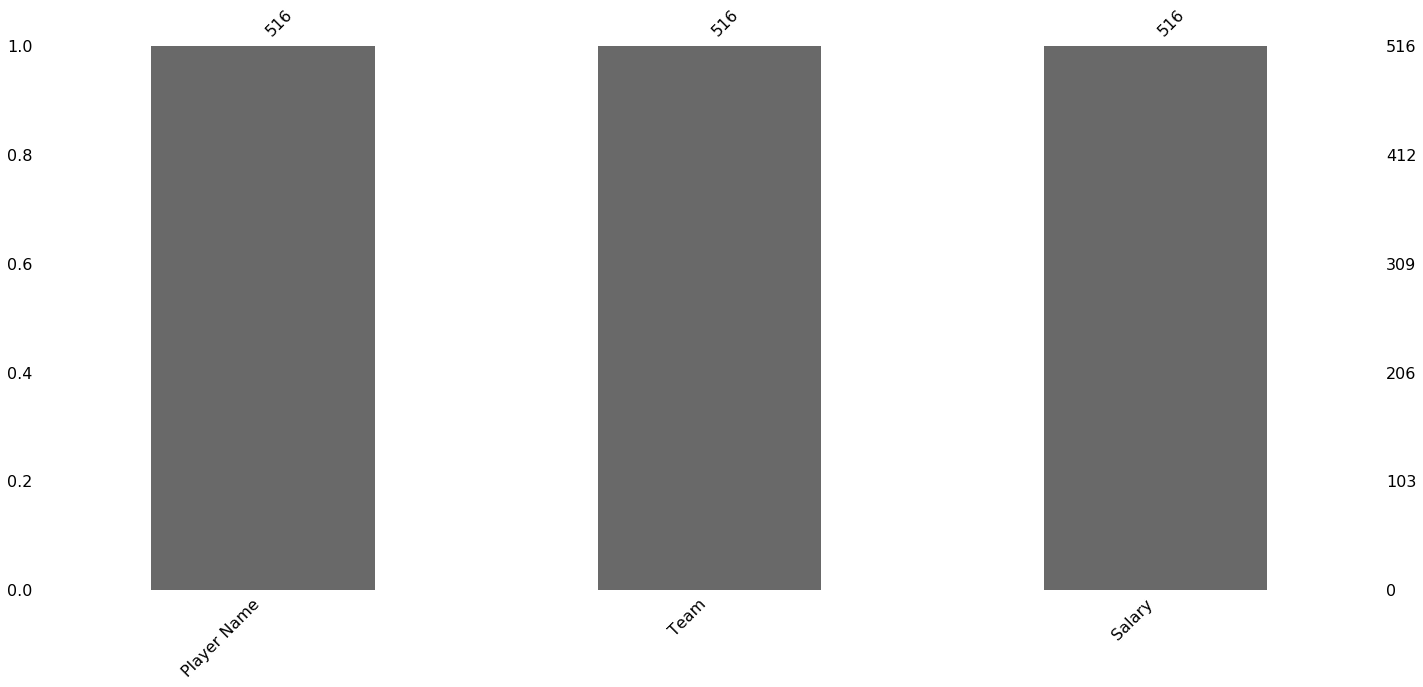

In [9]:
# Check count
msno.bar(df)

# We can also use:
#msno.matrix(df)

In [16]:
# We can save our cleaned dataset to CSV
df.to_csv('salaries.csv')

In [17]:
# URL 2: Stats Per Game
all_data2 = []
elems2 = soup2.find_all('tr')
for elem2 in elems2:
    player2 = []
    for b in elem2.select('td'):
        try:
            player2.append(b.get_text())
        except:
            pass
    all_data2.append(player2)
df2 = pd.DataFrame(data = all_data2)
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,Steven Adams,C,26,OKC,58,58,27.0,4.5,7.6,.591,...,.590,3.4,6.0,9.4,2.4,0.9,1.1,1.5,1.9,10.9
2,Bam Adebayo,PF,22,MIA,65,65,34.4,6.3,11.1,.567,...,.690,2.5,8.0,10.5,5.1,1.2,1.3,2.8,2.5,16.2
3,LaMarcus Aldridge,C,34,SAS,53,53,33.1,7.4,15.0,.493,...,.827,1.9,5.5,7.4,2.4,0.7,1.6,1.4,2.4,18.9
4,Nickeil Alexander-Walker,SG,21,NOP,41,0,12.2,1.9,5.5,.339,...,.607,0.2,1.8,2.0,1.8,0.3,0.2,1.0,1.1,5.1


We have to now clean our stats data sets using the following steps:
- Rename the column names, delete some columns if unneeded
- Delete the rows where there are missing data 
- Drop duplicates (take overall season stats for each player, be careful when merging!)
- Reset the index based on highest to lowest salary

In [18]:
# Rename columns
df2.columns = ['Player Name', 'Position', 'Age', 'Team', 'Games Played',
              'Games Started', 'Minutes Played', 'FG',
              'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA',
              '2P%', 'Effective FG%', 'FT','FTA', 'FT%', 
              'ORB', 'DRB', 'TRB','AST', 'STL', 'BLK', 'TOV',
              'PF', 'PTS']

# Drop missing values
df2.dropna(subset=['Player Name', 'Team'], inplace = True)
df2.head()

,Player Name,Position,Age,Team,Games Played,Games Started,Minutes Played,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
1,Steven Adams,C,26,OKC,58,58,27.0,4.5,7.6,.591,...,.590,3.4,6.0,9.4,2.4,0.9,1.1,1.5,1.9,10.9
2,Bam Adebayo,PF,22,MIA,65,65,34.4,6.3,11.1,.567,...,.690,2.5,8.0,10.5,5.1,1.2,1.3,2.8,2.5,16.2
3,LaMarcus Aldridge,C,34,SAS,53,53,33.1,7.4,15.0,.493,...,.827,1.9,5.5,7.4,2.4,0.7,1.6,1.4,2.4,18.9
4,Nickeil Alexander-Walker,SG,21,NOP,41,0,12.2,1.9,5.5,.339,...,.607,0.2,1.8,2.0,1.8,0.3,0.2,1.0,1.1,5.1
5,Grayson Allen,SG,24,MEM,30,0,16.6,2.6,5.9,.449,...,.857,0.2,2.0,2.2,1.4,0.2,0.0,0.8,1.2,7.4


In [19]:
# Check the list of player duplicates:
ids2 = df2["Player Name"]
df2[ids2.isin(ids2[ids2.duplicated()])].sort_values("Player Name")

,Player Name,Position,Age,Team,Games Played,Games Started,Minutes Played,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
94,Alec Burks,SG,28,TOT,59,18,27.3,4.8,11.9,.404,...,.896,0.7,3.7,4.4,2.9,1.0,0.3,1.4,2.0,15.1
95,Alec Burks,SG,28,GSW,48,18,29.0,5.1,12.5,.406,...,.897,0.8,3.9,4.7,3.1,1.0,0.4,1.6,2.2,16.1
96,Alec Burks,SG,28,PHI,11,0,20.2,3.5,9.1,.390,...,.889,0.5,2.7,3.3,1.8,0.7,0.0,0.8,1.2,10.7
373,Alex Len,C,26,SAC,9,0,16.7,2.9,4.7,.619,...,.700,2.9,4.2,7.1,0.6,0.2,1.4,1.2,2.3,6.6
372,Alex Len,C,26,ATL,40,9,18.6,3.6,6.5,.546,...,.630,1.7,4.0,5.8,1.1,0.5,0.8,1.0,2.3,8.7
371,Alex Len,C,26,TOT,49,9,18.3,3.4,6.2,.556,...,.637,1.9,4.1,6.0,1.0,0.4,0.9,1.0,2.3,8.3
148,Allen Crabbe,SG,27,MIN,9,0,14.6,1.2,3.8,.324,...,.500,0.1,1.2,1.3,0.6,0.0,0.0,0.6,1.2,3.2
146,Allen Crabbe,SG,27,TOT,37,1,17.6,1.7,4.8,.356,...,.714,0.3,1.8,2.1,0.9,0.4,0.1,0.5,1.3,4.6
147,Allen Crabbe,SG,27,ATL,28,1,18.6,1.9,5.1,.364,...,.750,0.4,2.0,2.3,1.0,0.5,0.1,0.4,1.3,5.1
183,Andre Drummond,C,26,CLE,8,8,28.1,7.3,13.1,.552,...,.513,3.0,8.1,11.1,1.8,1.5,1.4,3.6,3.1,17.5


In [20]:
# Drop the duplicates and use their overall season stats of players
df2.sort_values('Team', ascending = False)
df2 = df2.drop_duplicates(subset='Player Name', keep = 'first')
df2

,Player Name,Position,Age,Team,Games Played,Games Started,Minutes Played,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
1,Steven Adams,C,26,OKC,58,58,27.0,4.5,7.6,.591,...,.590,3.4,6.0,9.4,2.4,0.9,1.1,1.5,1.9,10.9
2,Bam Adebayo,PF,22,MIA,65,65,34.4,6.3,11.1,.567,...,.690,2.5,8.0,10.5,5.1,1.2,1.3,2.8,2.5,16.2
3,LaMarcus Aldridge,C,34,SAS,53,53,33.1,7.4,15.0,.493,...,.827,1.9,5.5,7.4,2.4,0.7,1.6,1.4,2.4,18.9
4,Nickeil Alexander-Walker,SG,21,NOP,41,0,12.2,1.9,5.5,.339,...,.607,0.2,1.8,2.0,1.8,0.3,0.2,1.0,1.1,5.1
5,Grayson Allen,SG,24,MEM,30,0,16.6,2.6,5.9,.449,...,.857,0.2,2.0,2.2,1.4,0.2,0.0,0.8,1.2,7.4
6,Jarrett Allen,C,21,BRK,64,58,25.7,4.2,6.5,.646,...,.620,3.0,6.4,9.5,1.3,0.6,1.3,1.1,2.3,10.6
7,Kadeem Allen,SG,27,NYK,10,0,11.7,1.9,4.4,.432,...,.636,0.2,0.7,0.9,2.1,0.5,0.2,0.8,0.7,5.0
8,Al-Farouq Aminu,PF,29,ORL,18,2,21.1,1.4,4.8,.291,...,.655,1.3,3.5,4.8,1.2,1.0,0.4,0.9,1.5,4.3
9,Justin Anderson,SF,26,BRK,3,0,5.7,0.3,2.0,.167,...,.500,0.0,0.7,0.7,0.0,0.0,0.3,0.0,0.7,1.0
10,Kyle Anderson,PF,26,MEM,59,20,19.3,2.3,4.7,.493,...,.652,0.9,3.4,4.4,2.2,0.8,0.5,0.9,1.4,5.7


In [21]:
# Reset index
df2 = df2.reset_index(drop=True)
df2.head(3)

,Player Name,Position,Age,Team,Games Played,Games Started,Minutes Played,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Steven Adams,C,26,OKC,58,58,27.0,4.5,7.6,.591,...,.590,3.4,6.0,9.4,2.4,0.9,1.1,1.5,1.9,10.9
1,Bam Adebayo,PF,22,MIA,65,65,34.4,6.3,11.1,.567,...,.690,2.5,8.0,10.5,5.1,1.2,1.3,2.8,2.5,16.2
2,LaMarcus Aldridge,C,34,SAS,53,53,33.1,7.4,15.0,.493,...,.827,1.9,5.5,7.4,2.4,0.7,1.6,1.4,2.4,18.9


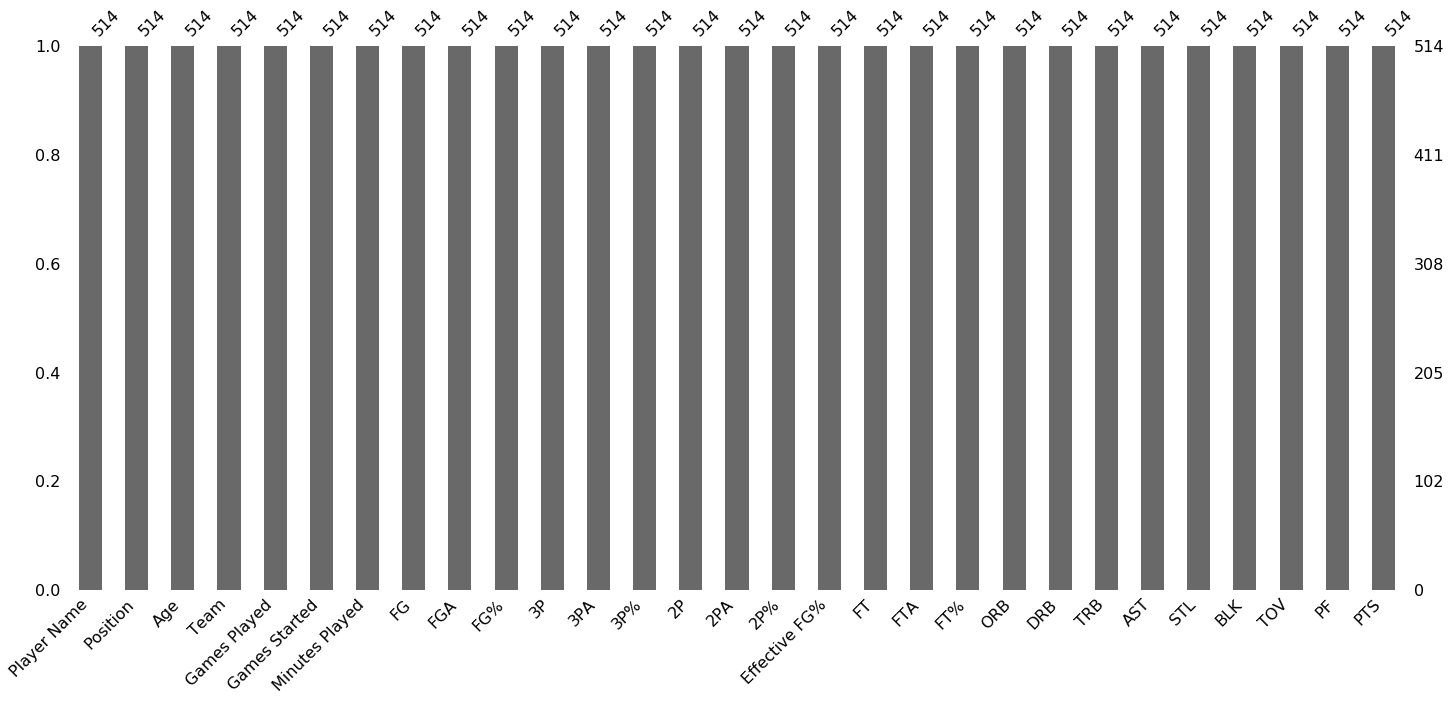

In [22]:
# Check count
msno.bar(df2)

In [23]:
# We can save our second cleaned dataset to CSV
df2.to_csv('basic_stats.csv')

In [24]:
# URL 3: Stats Advanced
all_data3 = []
elems3 = soup3.find_all('tr')
for elem3 in elems3:
    player3 = []
    for c in elem3.select('td'):
        try:
            player3.append(c.get_text())
        except:
            pass
    all_data3.append(player3)
df3 = pd.DataFrame(data = all_data3)
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,Steven Adams,C,26,OKC,58,1564,20.8,.605,.007,.413,...,,3.7,2.5,6.2,.190,,2.1,1.1,3.2,2.0
2,Bam Adebayo,PF,22,MIA,65,2235,20.6,.606,.018,.476,...,,4.6,3.6,8.1,.175,,1.6,2.1,3.6,3.2
3,LaMarcus Aldridge,C,34,SAS,53,1754,19.8,.571,.198,.241,...,,3.1,1.4,4.4,.122,,1.8,-0.5,1.3,1.5
4,Nickeil Alexander-Walker,SG,21,NOP,41,501,7.6,.441,.515,.123,...,,-0.7,0.4,-0.4,-0.034,,-3.5,-1.4,-4.9,-0.4


In [25]:
# Rename columns
df3.columns = ['Player Name', 'Position', 'Age', 'Team', 'Games Played', 
               'Total Minutes Played', 'PER', 'TS%', '3PAr',
               'FTr', 'ORB%', 'DRB%', 'TRB%','AST%', 'STL%', 'BLK%',
               'TOV%','USG%', 'N1', 'OWS', 'DWS', 'WS', 'WS/48', 
               'N2', 'OBPM', 'DBPM', 'BPM', 'VORP']

# # Drop None columns N1 and N2
df3 = df3.drop(columns = ['N1', 'N2'])

# Drop row missing values
df3.dropna(subset=['Player Name', 'Team'], inplace = True)
df3.head()

,Player Name,Position,Age,Team,Games Played,Total Minutes Played,PER,TS%,3PAr,FTr,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
1,Steven Adams,C,26,OKC,58,1564,20.8,.605,.007,.413,...,14.1,17.2,3.7,2.5,6.2,.190,2.1,1.1,3.2,2.0
2,Bam Adebayo,PF,22,MIA,65,2235,20.6,.606,.018,.476,...,17.5,20.8,4.6,3.6,8.1,.175,1.6,2.1,3.6,3.2
3,LaMarcus Aldridge,C,34,SAS,53,1754,19.8,.571,.198,.241,...,7.8,23.6,3.1,1.4,4.4,.122,1.8,-0.5,1.3,1.5
4,Nickeil Alexander-Walker,SG,21,NOP,41,501,7.6,.441,.515,.123,...,14.3,22.8,-0.7,0.4,-0.4,-0.034,-3.5,-1.4,-4.9,-0.4
5,Grayson Allen,SG,24,MEM,30,498,11.4,.577,.517,.199,...,10.7,17.9,0.5,0.3,0.7,.070,-1.0,-1.5,-2.6,-0.1


In [26]:
# Check the list of player duplicates:
ids3 = df3["Player Name"]
df3[ids3.isin(ids3[ids3.duplicated()])].sort_values("Player Name")

,Player Name,Position,Age,Team,Games Played,Total Minutes Played,PER,TS%,3PAr,FTr,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
94,Alec Burks,SG,28,TOT,59,1612,16.0,.549,.389,.358,...,9.5,23.8,1.9,1.1,2.9,.088,0.6,-0.7,-0.2,0.7
95,Alec Burks,SG,28,GSW,48,1390,16.1,.552,.373,.373,...,9.8,23.8,1.6,0.8,2.5,.085,0.7,-0.6,0.1,0.7
96,Alec Burks,SG,28,PHI,11,222,14.9,.527,.490,.270,...,7.4,23.5,0.2,0.2,0.5,.103,-0.2,-1.5,-1.7,0.0
373,Alex Len,C,26,SAC,9,150,20.3,.636,.000,.238,...,19.2,16.7,0.3,0.2,0.5,.165,-0.7,0.1,-0.6,0.1
372,Alex Len,C,26,ATL,40,745,17.5,.590,.215,.312,...,11.7,18.6,1.1,0.6,1.8,.113,-0.2,-0.3,-0.4,0.3
371,Alex Len,C,26,TOT,49,895,18.0,.596,.185,.301,...,12.8,18.3,1.4,0.9,2.3,.122,-0.2,-0.2,-0.5,0.3
148,Allen Crabbe,SG,27,MIN,9,131,1.1,.416,.765,.059,...,12.5,12.5,-0.2,0.0,-0.2,-0.068,-6.6,-3.2,-9.9,-0.3
146,Allen Crabbe,SG,27,TOT,37,653,6.0,.470,.672,.079,...,8.5,12.7,-0.2,0.1,-0.1,-0.007,-3.7,-1.5,-5.3,-0.5
147,Allen Crabbe,SG,27,ATL,28,522,7.2,.482,.650,.084,...,7.5,12.7,0.0,0.1,0.1,.008,-3.0,-1.1,-4.1,-0.3
183,Andre Drummond,C,26,CLE,8,225,21.1,.573,.133,.371,...,19.2,28.7,-0.1,0.3,0.3,.054,-0.8,0.4,-0.5,0.1


In [27]:
# Drop the duplicates and use their overall season stats of players
df3.sort_values('Team', ascending = False)
df3 = df3.drop_duplicates(subset='Player Name', keep = 'first')
df3

,Player Name,Position,Age,Team,Games Played,Total Minutes Played,PER,TS%,3PAr,FTr,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
1,Steven Adams,C,26,OKC,58,1564,20.8,.605,.007,.413,...,14.1,17.2,3.7,2.5,6.2,.190,2.1,1.1,3.2,2.0
2,Bam Adebayo,PF,22,MIA,65,2235,20.6,.606,.018,.476,...,17.5,20.8,4.6,3.6,8.1,.175,1.6,2.1,3.6,3.2
3,LaMarcus Aldridge,C,34,SAS,53,1754,19.8,.571,.198,.241,...,7.8,23.6,3.1,1.4,4.4,.122,1.8,-0.5,1.3,1.5
4,Nickeil Alexander-Walker,SG,21,NOP,41,501,7.6,.441,.515,.123,...,14.3,22.8,-0.7,0.4,-0.4,-0.034,-3.5,-1.4,-4.9,-0.4
5,Grayson Allen,SG,24,MEM,30,498,11.4,.577,.517,.199,...,10.7,17.9,0.5,0.3,0.7,.070,-1.0,-1.5,-2.6,-0.1
6,Jarrett Allen,C,21,BRK,64,1647,20.3,.658,.012,.574,...,12.2,15.0,4.3,2.8,7.1,.207,1.0,1.1,2.1,1.7
7,Kadeem Allen,SG,27,NYK,10,117,14.0,.512,.364,.250,...,14.1,20.6,0.1,0.1,0.1,.053,0.0,-0.6,-0.6,0.0
8,Al-Farouq Aminu,PF,29,ORL,18,380,7.6,.395,.419,.337,...,14.7,13.2,-0.4,0.5,0.1,.016,-4.5,1.4,-3.1,-0.1
9,Justin Anderson,SF,26,BRK,3,17,-3.8,.218,.500,.333,...,0.0,16.9,-0.1,0.0,-0.1,-0.167,-12.8,-2.3,-15.1,-0.1
10,Kyle Anderson,PF,26,MEM,59,1140,13.0,.542,.221,.236,...,15.1,13.3,0.9,1.4,2.2,.095,-1.3,1.9,0.6,0.7


In [28]:
# Reset index
df3 = df3.reset_index(drop=True)
df3.head(3)

,Player Name,Position,Age,Team,Games Played,Total Minutes Played,PER,TS%,3PAr,FTr,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,Steven Adams,C,26,OKC,58,1564,20.8,.605,.007,.413,...,14.1,17.2,3.7,2.5,6.2,.190,2.1,1.1,3.2,2.0
1,Bam Adebayo,PF,22,MIA,65,2235,20.6,.606,.018,.476,...,17.5,20.8,4.6,3.6,8.1,.175,1.6,2.1,3.6,3.2
2,LaMarcus Aldridge,C,34,SAS,53,1754,19.8,.571,.198,.241,...,7.8,23.6,3.1,1.4,4.4,.122,1.8,-0.5,1.3,1.5


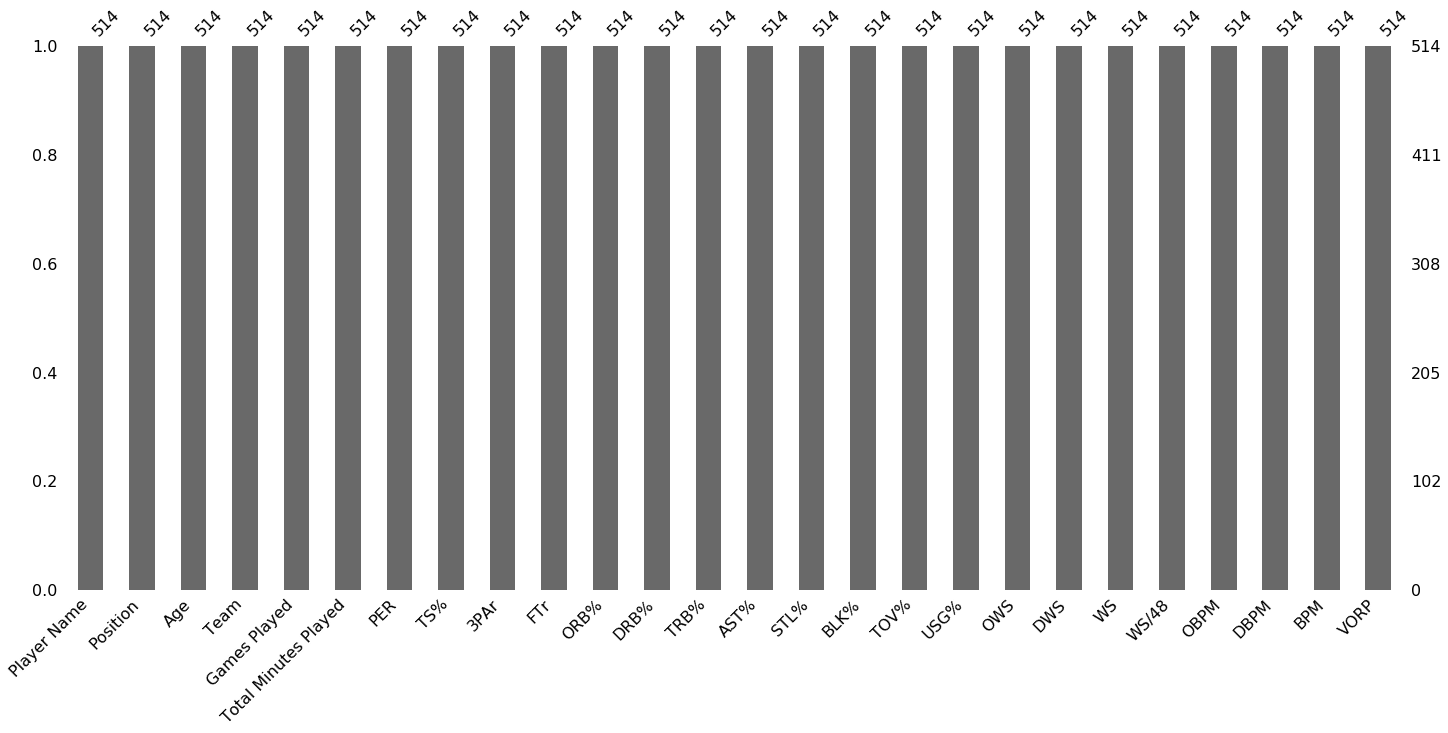

In [29]:
# Check count
msno.bar(df3)

In [30]:
# We can save our third cleaned dataset to CSV
df3.to_csv('advanced_stats.csv')

__Note:__ Another way of getting the data instead of web scraping would be to download and import the Excel/CSV files straight into JN. It ends up being easier to modify the datasets in Excel but this method isn't great if the data gets updated. Web scraping is used for this project but I still put some of the code in the *cell below* if someone wants to play with the downloaded datasets.

In [31]:
# # Import the players' salaries
# df4 = pd.read_csv('salaries.csv')
# df4 = df4.drop(columns = ['Rank'])

# # We count 545 rows
# print(df4.count())
# # We count 516 unique players
# print(df4.nunique())

# # Drop the duplicates and keep highest earning of duplicated players
# df4.sort_values('Salary', ascending = False)
# df4 = df4.drop_duplicates(subset='Player Name', keep = 'first')
# df4

# # Import the players' stats
# df5 = pd.read_csv('basic_stats.csv')

# # We count 624 rows
# print(df5.count())
# # We count 514 unique players
# print(df5.nunique())

# # Drop the duplicates and use their overall season stats of players
# df5.sort_values('Team', ascending = False)
# df5 = df5.drop_duplicates(subset='Player', keep = 'first')
# df5

# df6 = pd.merge(df5,df4, on = 'Player')
# df6 = df6.drop(columns = ['Rk'])
# df6

### Exploratory Data Analysis:

In this section, we go over the variables present in the data, merge the 3 datasets above into one dataframe, make sure to clean the final dataset well in order to possibly create good models.

Below we have a brief explanation for each of the variables [(link also available here)](https://www.basketball-reference.com/about/glossary.html):


__Basic Stats__:

- Position: Position they play on the court
- Games Played: Total games played this season
- Games Started: Total games where the player started in the game this season
- Minutes Played: Average minutes played per game
- Total Minutes Played: Total minutes played this season
- FG: Field goals (scoring a 2 or 3 points basket) per game
- FGA: Field goals attempts per game
- FG%: Field goals percentage (FG/FGA)
- 3P: 3 points field goals per game
- 3PA: 3 points attempts per game
- 3P%: 3 point field goals percentage (3P/3PA)
- 2P: Same concept as 3P but for 2 points
- 2PA: Same concept as 3PA but for 2 points
- 2P%: Same concept as 3P% but for 2 points
- Effective FG%: This statistic adjusts for the fact that a 3-point field goal is worth one more point than a 2-point field goal. For example, suppose Player A goes 4 for 10 with 2 threes, while Player B goes 5 for 10 with 0 threes. Each player would have 10 points from field goals, and thus would have the same effective field goal percentage (FG + 0.5 * 3P) / FGA
- FT: Free throws field goals per game
- FTA: Same concept as 3PA but for free throws
- FT%: (FT/FT%)
- ORB: Offensive rebounds per game
- DRB: Defensive rebounds per game
- TRB: Total rebounds per game (ORB + DRB) 
- AST: Assists per game
- STL: Steals per game
- BLK: Blocks per game
- TOV: Turnover per game
- PF: Fouls per game
- PTS: Points per game

__Advanced Stats__:

- TS%: True shooting percentage
- 3PAr: Overall 3 points attempts rate
- FTr: Overall free throw attempt rate
- ORB%: Estimate of the percentage of available offensive rebounds a player grabbed while he was on the floor
- DRB%: Estimate of the percentage of available defensive rebounds a player grabbed while he was on the floor
- TRB%: Estimate of the percentage of available rebounds a player grabbed while he was on the floor.
- AST%: Estimate of the percentage of teammate field goals a player assisted while he was on the floor
- STL%: Estimate of the percentage of opponent possessions that end with a steal by the player while he was on the floor
- BLK%: Estimate of the percentage of opponent two-point field goal attempts blocked by the player while he was on the floor
- TOV%: Estimate of turnovers per 100 plays
- USG%: Estimate of the percentage of team plays used by a player while he was on the floor.
- OWS: Offensive win shares
- DWS: Defensive win shares
- WS: Estimate of the number of wins contributed by a player
- WS/48: Estimate of the number of wins contributed by the player per 48 minutes
- PER: Player Efficiency Rating: sums up all a player's positive accomplishments, subtracts the negative accomplishments, and returns a per-minute rating of a player's performance
- OBPM: Offensive box plus minus
- DBPM: Defensive box plus minus
- BPM: Box plus minus. Estimate of the points per 100 possessions that a player contributed above a league-average player, translated to an average team
- VORP: Value over replacement player, a box score estimate of the points per 100 TEAM possessions that a player contributed above a replacement-level (-2.0) player, translated to an average team and prorated to an 82-game season. Multiply by 2.70 to convert to wins over replacement

__Data Issue:__ Merging our data sets is usually an easy task that could be performed in a few lines as shown in the cell below. However, merging the salaries frame was tough as I have found a data quality issue within the salaries and the statistics data sets where the player names did not match (67 cases). I addressed this issue on Excel by checking each case personally. As it turned out, 17 players had their names misspelled (mainly missing Jr. in their name or included special letters) while the other 50 players were in the G-league as a 2-way-contract, which we forementioned would not be considered in this project. The players marked with multiple positions (8 cases) in the combined data set will be cleaned up during the cleaning process as they do not meet one or both of the following criteria: the salary quota and/or the experience level.

The updated salaries file was named *__"salaries_updated"__* and the combined file for all three data sets was called *__"combined_sets"__* which contains __464 players__.

In [32]:
# Merging data sets when data is clean
# stats_df = pd.merge(df,df2, on = 'Player Name')
# stats_df

In [22]:
# All data sets into the same dataframe
pd.set_option('display.width', 320)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
all_df = pd.read_excel('combined_sets.xlsx')

# Edit and clean data set
all_df.fillna(0, inplace=True) # input 0 for empty cells as the missing values were nothing more than a 0/0 issue
all_df = all_df[all_df.Position != 'SF-SG']
all_df = all_df[all_df.Position != 'SF-SG'] # Drop the 8 cases where players had two positions 
all_df = all_df[all_df.Position != 'SF-PF'] # They were dropped due to salary quota and/or experience level
all_df = all_df[all_df.Position != 'PF-SF']
all_df = all_df[all_df.Position != 'C-PF']
all_df = all_df.reset_index(drop=True)

# change column names to fit ML models if needed
#all_df.columns = [i.replace(' ', '_').lower() for i in all_df.columns]

# Styling to see distinct column(s) with a red bar style
# all_df.style.bar(subset = ['Minutes Played', ''], color='#d65f5f')

all_df.head()

,Rank,Player Name,Position,Age,Team,Games Played,Games Started,Minutes Played,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,Effective FG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Total Minutes Played,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Salary ($)
0,1,Stephen Curry,PG,31,GSW,5,5,27.8,6.6,16.4,0.402,2.4,9.8,0.245,4.2,6.6,0.636,0.476,5.2,5.2,1.000,0.8,4.4,5.2,6.6,1.0,0.4,3.2,2.2,20.8,139,21.7,0.557,0.598,0.317,3.0,17.8,10.1,42.3,1.7,1.3,14.6,33.6,0.2,0.1,0.3,0.104,4.5,-0.6,3.9,0.2,40231758
1,2,Chris Paul,PG,34,OKC,63,63,31.8,6.3,12.8,0.489,1.6,4.4,0.362,4.7,8.3,0.557,0.552,3.6,4.0,0.900,0.3,4.6,4.9,6.8,1.6,0.1,2.2,2.2,17.7,2003,21.7,0.609,0.347,0.311,1.2,15.5,8.6,33.4,2.4,0.4,13.0,23.2,5.5,2.5,8.1,0.194,3.1,1.2,4.3,3.2,38506482
2,3,Russell Westbrook,PG,31,HOU,53,53,35.9,10.7,22.6,0.474,1.0,3.8,0.254,9.8,18.8,0.518,0.495,5.1,6.5,0.777,1.8,6.3,8.0,7.0,1.7,0.3,4.5,3.5,27.5,1905,21.5,0.539,0.168,0.289,5.1,18.4,11.7,35.0,2.1,0.8,14.9,34.4,2.1,2.3,4.3,0.109,1.9,-0.1,1.8,1.8,38178000
3,4,James Harden,SG,30,HOU,61,61,36.7,9.9,22.7,0.435,4.4,12.6,0.352,5.4,10.1,0.538,0.533,10.1,11.8,0.861,1.0,5.3,6.4,7.4,1.7,0.9,4.5,3.4,34.4,2241,28.4,0.616,0.555,0.519,3.0,15.3,9.1,34.4,2.2,2.0,13.8,36.4,8.7,2.7,11.5,0.245,7.9,1.2,9.0,6.3,37800000
4,5,LeBron James,PG,35,LAL,60,60,34.9,9.8,19.6,0.498,2.2,6.4,0.349,7.6,13.3,0.570,0.555,4.0,5.7,0.697,1.0,6.9,7.9,10.6,1.2,0.5,4.0,1.8,25.7,2094,26.0,0.582,0.324,0.292,3.1,21.0,12.3,49.7,1.7,1.3,15.3,31.6,6.1,3.4,9.5,0.218,6.8,1.9,8.7,5.7,37436858


In [23]:
# For loop to show all columns missing values as a list
missing_data = all_df.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")    

Rank
False    456
Name: Rank, dtype: int64

Player Name
False    456
Name: Player Name, dtype: int64

Position
False    456
Name: Position, dtype: int64

Age
False    456
Name: Age, dtype: int64

Team
False    456
Name: Team, dtype: int64

Games Played
False    456
Name: Games Played, dtype: int64

Games Started
False    456
Name: Games Started, dtype: int64

Minutes Played
False    456
Name: Minutes Played, dtype: int64

FG
False    456
Name: FG, dtype: int64

FGA
False    456
Name: FGA, dtype: int64

FG%
False    456
Name: FG%, dtype: int64

3P
False    456
Name: 3P, dtype: int64

3PA
False    456
Name: 3PA, dtype: int64

3P%
False    456
Name: 3P%, dtype: int64

2P
False    456
Name: 2P, dtype: int64

2PA
False    456
Name: 2PA, dtype: int64

2P%
False    456
Name: 2P%, dtype: int64

Effective FG%
False    456
Name: Effective FG%, dtype: int64

FT
False    456
Name: FT, dtype: int64

FTA
False    456
Name: FTA, dtype: int64

FT%
False    456
Name: FT%, dtype: int64

ORB
False    456

In [73]:
# Write a function that sums all important statistics for any specified dataframe
def stats(data): 
    df = {}
    df['null_sum'] = data.isnull().sum() # Sum missing values
    df['null_pct'] = data.isnull().mean() # Percentage missing values
    df['dtypes'] = data.dtypes # data type
    df['count'] = data.count() # number of row values
    df['mean'] = data.mean() # mean of values
    df['median'] = data.median() # median of values
    df['min'] = data.min() # min of values
    df['max'] = data.max() # max of values
    
    return pd.DataFrame(df)

stats(all_df)

,null_sum,null_pct,dtypes,count,mean,median,min,max
2P,0,0.0,float64,456,2.428728e+00,2.000000e+00,0,9.8
2P%,0,0.0,float64,456,5.009627e-01,5.110000e-01,0,1
2PA,0,0.0,float64,456,4.665132e+00,3.800000e+00,0,18.8
3P,0,0.0,float64,456,1.011842e+00,9.000000e-01,0,4.4
3P%,0,0.0,float64,456,2.987259e-01,3.435000e-01,0,1
3PA,0,0.0,float64,456,2.886184e+00,2.500000e+00,0,12.6
3PAr,0,0.0,float64,456,3.822127e-01,3.940000e-01,0,1
AST,0,0.0,float64,456,2.059649e+00,1.500000e+00,0,10.6
AST%,0,0.0,float64,456,1.339934e+01,1.070000e+01,0,49.7
Age,0,0.0,int64,456,2.574342e+01,2.500000e+01,19,43


In [85]:
# Check which columns are of int and float type specifically
all_df_num_columns = all_df.select_dtypes(include=['float64', 'int64']).columns
all_df_num_columns

Index(['Rank', 'Age', 'Games Played', 'Games Started', 'Minutes Played', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'Effective FG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Total Minutes Played', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%',
       'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Salary ($)'],
      dtype='object')

### Quick Visualization of Compiled Data Set:

Here we look at the different correlations between variables and their distributions to decide which variables should or should not be considered. Eventually, we want to predict the win shares based on the statistics that are the most correlated. We use pyplot, matplotlib and seaborn to visualize.

Text(0, 0.5, 'Winning Shares')

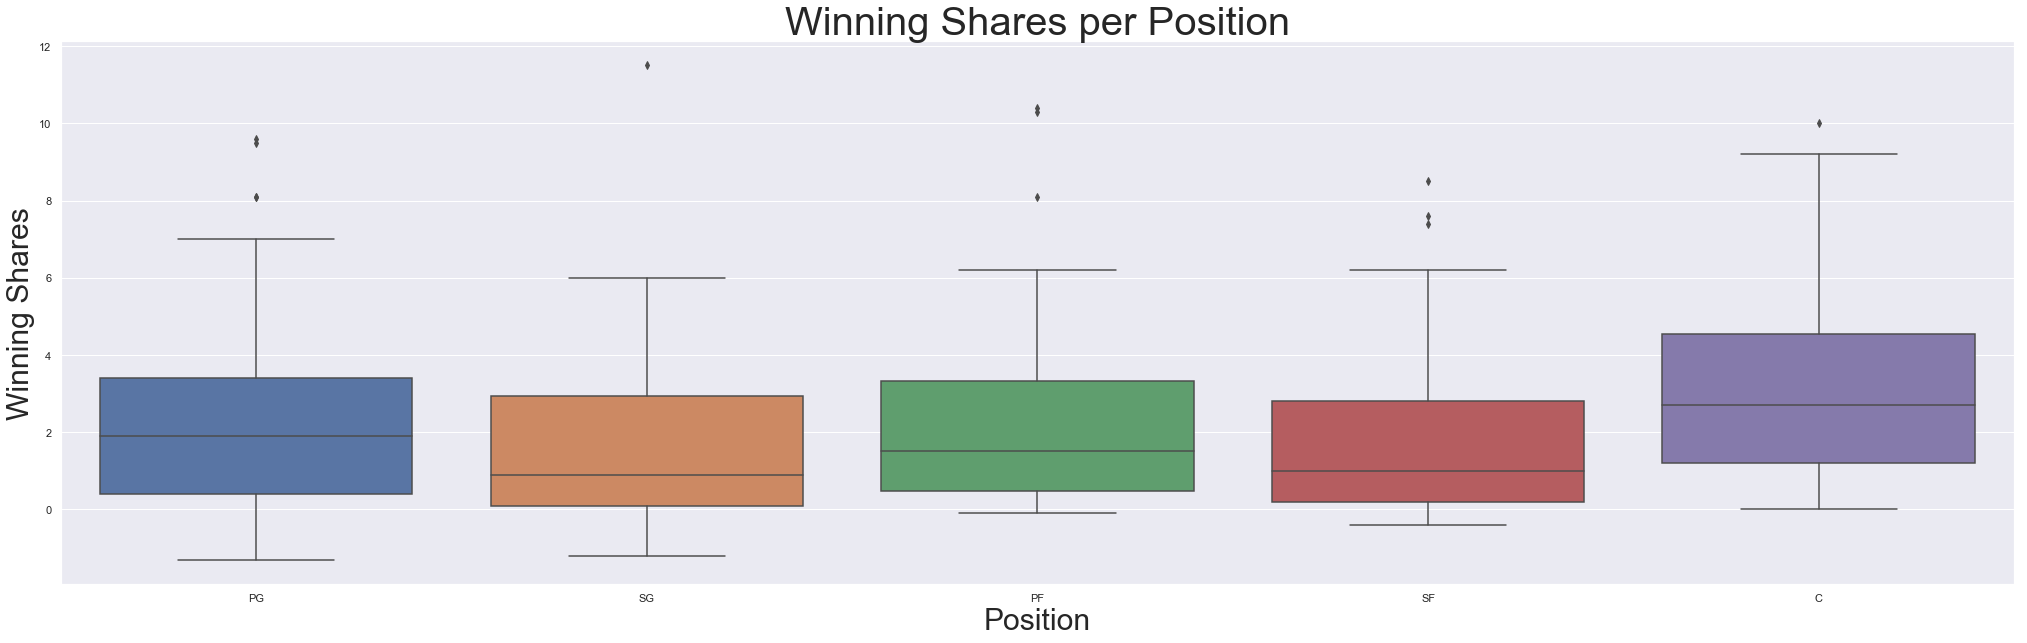

In [94]:
# Plotting Winning Shares per Position
plt.figure(figsize=(35,10)) # adjust the fig size to see everything
WS_per_Position_plot = sns.boxplot(all_df['Position'], all_df['WS'])
WS_per_Position_plot.set_title('Winning Shares per Position', fontsize = 40)
WS_per_Position_plot.set_xlabel("Position",fontsize = 30)
WS_per_Position_plot.set_ylabel("Winning Shares",fontsize = 30)

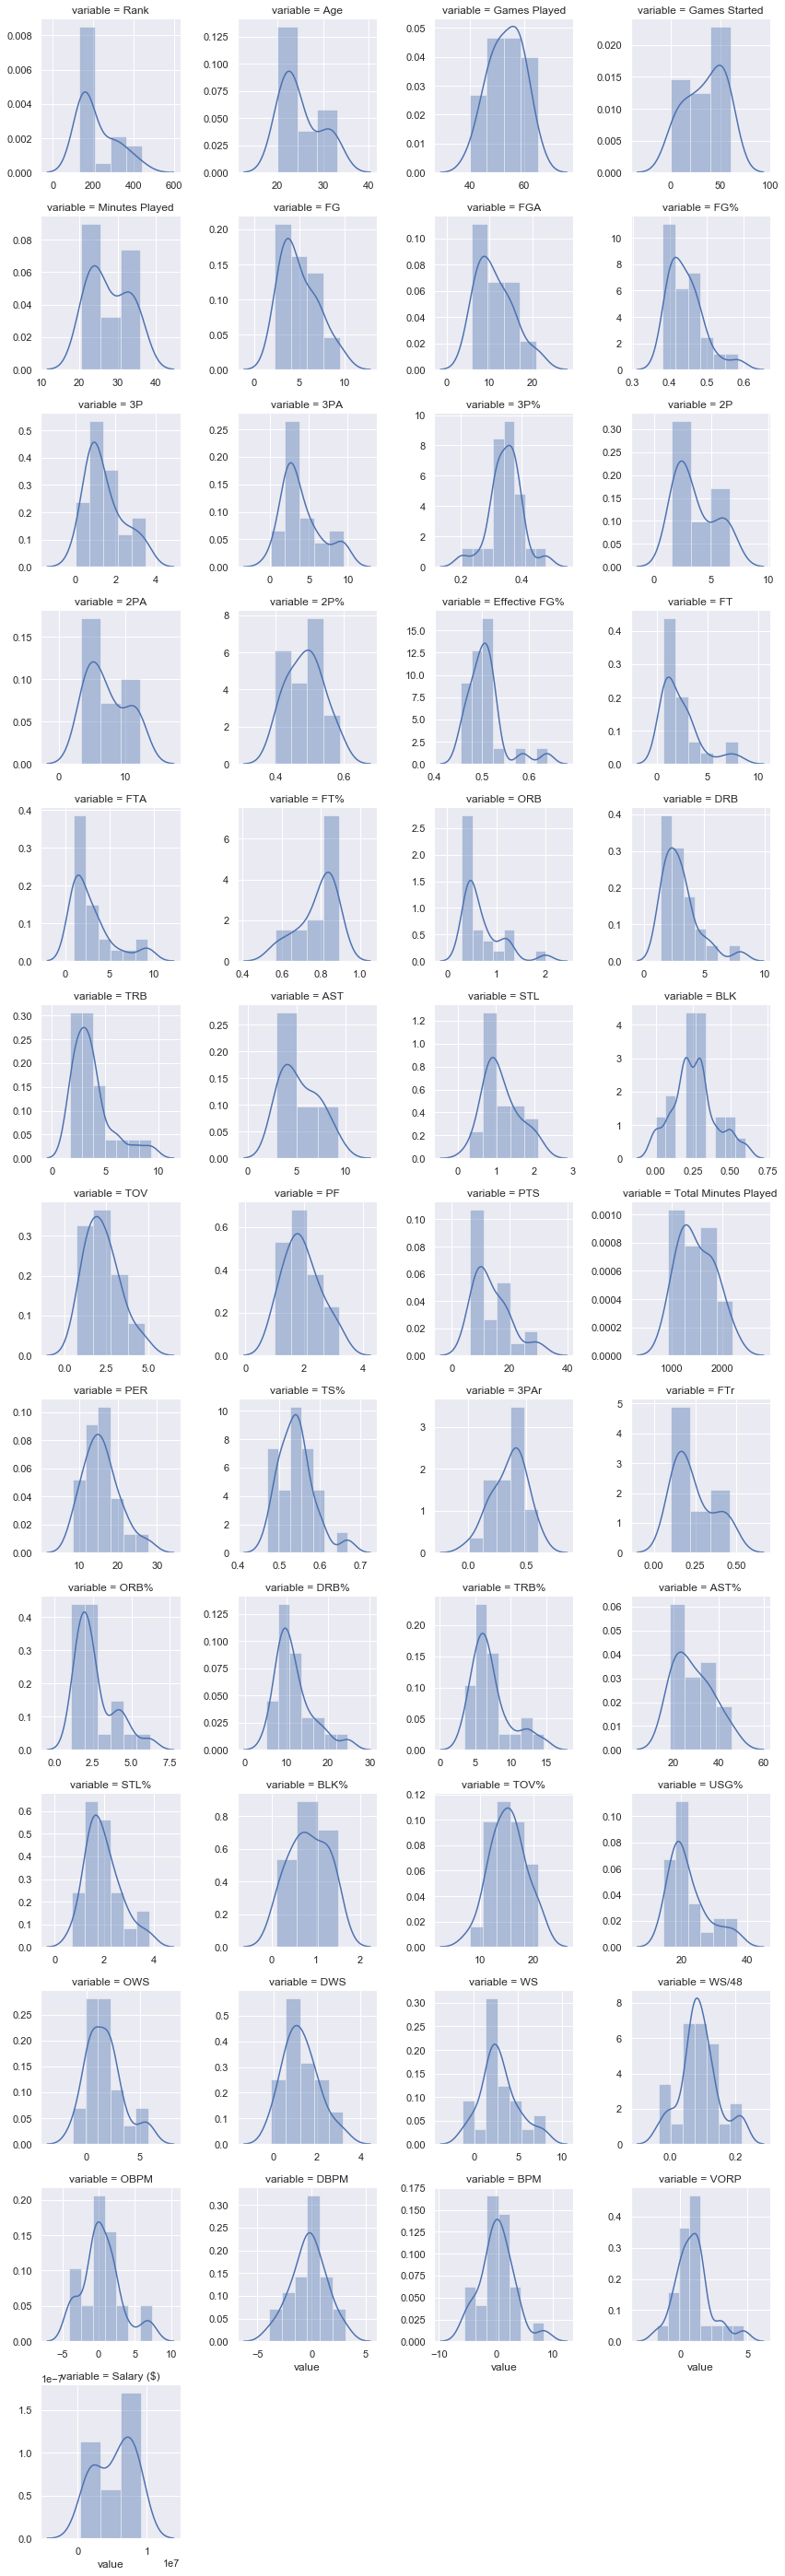

In [98]:
# Function to check the distribution for every numerical variable
def histograms_numeric_columns(df, numerical_columns):
    '''
    Takes df, numerical columns as list
    Returns a group of histagrams
    '''
    f = pd.melt(df, value_vars=numerical_columns) 
    g = sns.FacetGrid(f, col='variable',  col_wrap=4, sharex=False, sharey=False)
    g = g.map(sns.distplot, 'value')
    return g

#histograms_numeric_columns(all_df, all_df_num_columns)


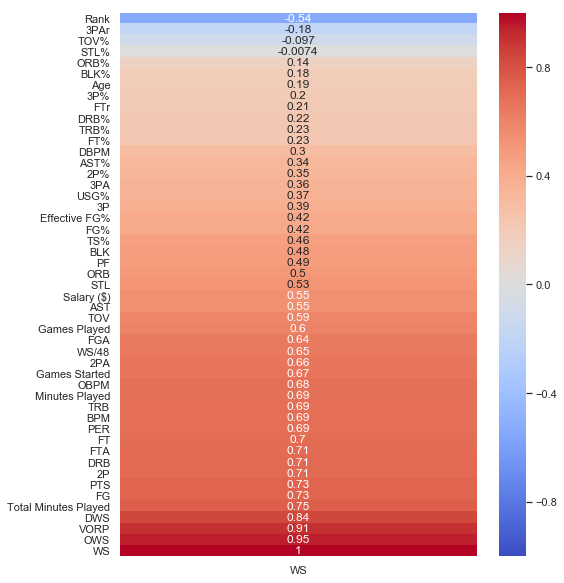

In [88]:
# Function to check the correlation between every numerical variable and the dependent variable
def heatmap_numeric_w_dependent_variable(df, dependent_variable):
    '''
    Takes df, a dependant variable as str
    Returns a heatmap of all independent variables' correlations with dependent variable 
    '''
    plt.figure(figsize=(8, 10))
    g = sns.heatmap(df.corr()[[dependent_variable]].sort_values(by=dependent_variable), 
                    annot=True, 
                    cmap='coolwarm', 
                    vmin=-1,
                    vmax=1) 
    return g

heatmap_numeric_w_dependent_variable(all_df, 'WS')

In [97]:
# Function to check for outliers using scatter plots
def scatter_plots(df, numerical_cols, target_col):
    '''
    Take a dataframe, a list of numerical columns, a target column as string
    Return a group of scatter plots
    '''
    # Calculate the number of rows
    num_rows = (len(numerical_cols) // 3) + 1
    # Generate a 3 x n subplots frame
    fix, ax = plt.subplots(num_rows, 3, sharey='row', figsize=(15,20))

    # Define a function to iterate through a list and divide them into chunks
    def chunker(seq, size):
        return (seq[pos:pos + size] for pos in range(0, len(seq), size))
    
    # Iterate through numerical_cols and generate each subplot
    for y, plot_group in enumerate(chunker((numerical_cols), 3)):
        for x, col in enumerate(plot_group):
            sub_ax = ax[y][x]
            plots = sub_ax.scatter(df[col], df[target_col], s=2)
            plots_titles = sub_ax.set_title(col)
    return (plots, plots_titles)

#scatter_plots(all_df, all_df_num_columns, 'WS')

### Variables Discussion:

Observing the correlation plot and the distribution curves, I decided to get rid off these following columns:
- 
- 
- 
- 


### Making Our Starting Five:

We first classify each player based on the position they play, the salary criteria (mentioned in the introduction), the number of games played (approximately 45% of total games) and the average minutes played (20 minutes ave per game based on the distribution). Granted that many players can play more than one position, we will focus on one distinct position per player.

#### - Point Guard (PG):

In [62]:
# Create a new df where we only see PGs
PG_df = all_df.loc[all_df['Position'] == 'PG'] # select PGs: drops to 81 players
PG_df = PG_df.loc[PG_df['Salary ($)'] <= 9400000] # earns less than ave quota: drops to 55 players
PG_df = PG_df.loc[PG_df['Games Played'] >= 30] # played more than 30 games: drops to 40 players
PG_df = PG_df.loc[PG_df['Minutes Played'] >= 20] # played more than 20 minutes a game: drops to 24 players
PG_df

# Save to CSV:
#PG_df.to_csv('PGs.csv')

,Rank,Player Name,Position,Age,Team,Games Played,Games Started,Minutes Played,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,Effective FG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Total Minutes Played,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Salary ($)
129,130,George Hill,PG,33,MIL,52,0,21.2,3.4,6.5,0.530,1.4,2.9,0.480,2.0,3.5,0.571,0.638,1.3,1.6,0.831,0.9,2.1,3.0,2.9,0.8,0.1,0.9,1.4,9.6,1103,17.5,0.668,0.452,0.247,4.3,9.2,6.9,18.4,1.7,0.3,11.6,15.8,3.2,1.9,5.1,0.220,1.8,1.4,3.2,1.5,9133907
131,132,Fred VanVleet,PG,25,TOR,48,48,35.8,6.0,14.6,0.409,2.7,7.0,0.388,3.3,7.6,0.430,0.503,2.9,3.5,0.843,0.4,3.4,3.8,6.6,1.9,0.3,2.3,2.5,17.6,1719,16.0,0.546,0.482,0.237,1.1,9.7,5.5,27.4,2.5,0.7,12.4,22.0,2.2,2.7,4.9,0.136,1.0,1.3,2.3,1.8,9000000
132,133,Ja Morant,PG,20,MEM,59,59,30.0,6.7,13.6,0.491,0.9,2.4,0.367,5.8,11.2,0.517,0.523,3.5,4.5,0.770,0.7,2.8,3.5,6.9,0.9,0.3,3.2,1.5,17.6,1771,18.0,0.568,0.174,0.331,2.7,9.5,6.2,34.6,1.4,0.7,17.2,26.0,2.2,1.2,3.4,0.093,1.6,-1.3,0.4,1.1,8730240
134,135,Lonzo Ball,PG,22,NOP,56,47,32.4,4.6,11.2,0.412,2.5,6.5,0.383,2.1,4.7,0.453,0.523,0.7,1.2,0.567,1.1,5.1,6.2,7.0,1.4,0.5,3.1,2.0,12.4,1817,13.7,0.529,0.578,0.107,3.6,16.6,10.1,29.3,2.0,1.4,20.7,18.6,0.7,1.9,2.6,0.068,0.4,0.6,1.0,1.3,8719320
141,142,Ben Simmons,PG,23,PHI,54,54,35.7,6.7,11.4,0.585,0.0,0.1,0.333,6.6,11.3,0.588,0.587,3.3,5.3,0.627,2.0,5.8,7.8,8.2,2.1,0.6,3.6,3.2,16.7,1930,20.8,0.608,0.010,0.460,6.2,18.0,12.1,34.8,2.9,1.4,20.6,20.9,3.8,3.2,7.0,0.174,1.4,2.4,3.9,2.9,8113930
144,145,Elfrid Payton,PG,25,NYK,45,36,27.7,4.3,9.8,0.439,0.3,1.5,0.203,4.0,8.2,0.482,0.455,1.1,1.9,0.570,1.2,3.6,4.7,7.2,1.6,0.4,2.1,2.0,10.0,1246,16.0,0.470,0.157,0.195,4.3,14.1,9.1,38.6,2.7,1.3,16.7,19.5,0.5,1.2,1.7,0.065,-0.3,0.3,0.0,0.6,8000000
151,152,Luka Dončić,PG,20,DAL,54,54,33.3,9.5,20.6,0.461,2.9,9.1,0.318,6.6,11.5,0.574,0.531,6.8,9.1,0.752,1.3,8.0,9.3,8.7,1.1,0.2,4.2,2.5,28.7,1799,27.7,0.584,0.442,0.442,4.1,24.7,14.6,45.3,1.6,0.5,14.6,37.0,5.8,2.3,8.1,0.215,7.3,1.1,8.4,4.7,7683360
156,157,Derrick Rose,PG,31,DET,50,15,26.0,7.4,15.1,0.490,0.9,2.9,0.306,6.5,12.1,0.535,0.520,2.4,2.8,0.871,0.5,1.9,2.4,5.6,0.8,0.3,2.5,1.0,18.1,1298,21.1,0.555,0.195,0.185,2.3,8.3,5.3,40.5,1.5,1.0,13.4,31.6,1.9,0.6,2.5,0.093,4.0,-1.7,2.2,1.4,7317073
158,159,D.J. Augustin,PG,32,ORL,49,6,24.8,3.2,8.1,0.393,1.2,3.6,0.345,2.0,4.6,0.430,0.469,2.8,3.2,0.885,0.4,1.9,2.2,4.6,0.6,0.0,1.4,1.1,10.4,1215,14.2,0.548,0.438,0.395,1.5,8.3,4.8,26.7,1.2,0.1,12.9,19.1,1.8,0.8,2.6,0.101,-0.3,-1.0,-1.4,0.2,7250000
169,170,Darius Garland,PG,20,CLE,59,59,30.9,4.7,11.8,0.401,1.8,5.0,0.355,3.0,6.8,0.434,0.476,1.1,1.2,0.875,0.5,1.4,1.9,3.9,0.7,0.1,2.6,1.6,12.3,1824,8.5,0.498,0.423,0.103,1.6,5.2,3.4,18.5,1.1,0.2,17.1,20.7,-1.3,0.0,-1.3,-0.035,-2.7,-2.9,-5.6,-1.7,6400920


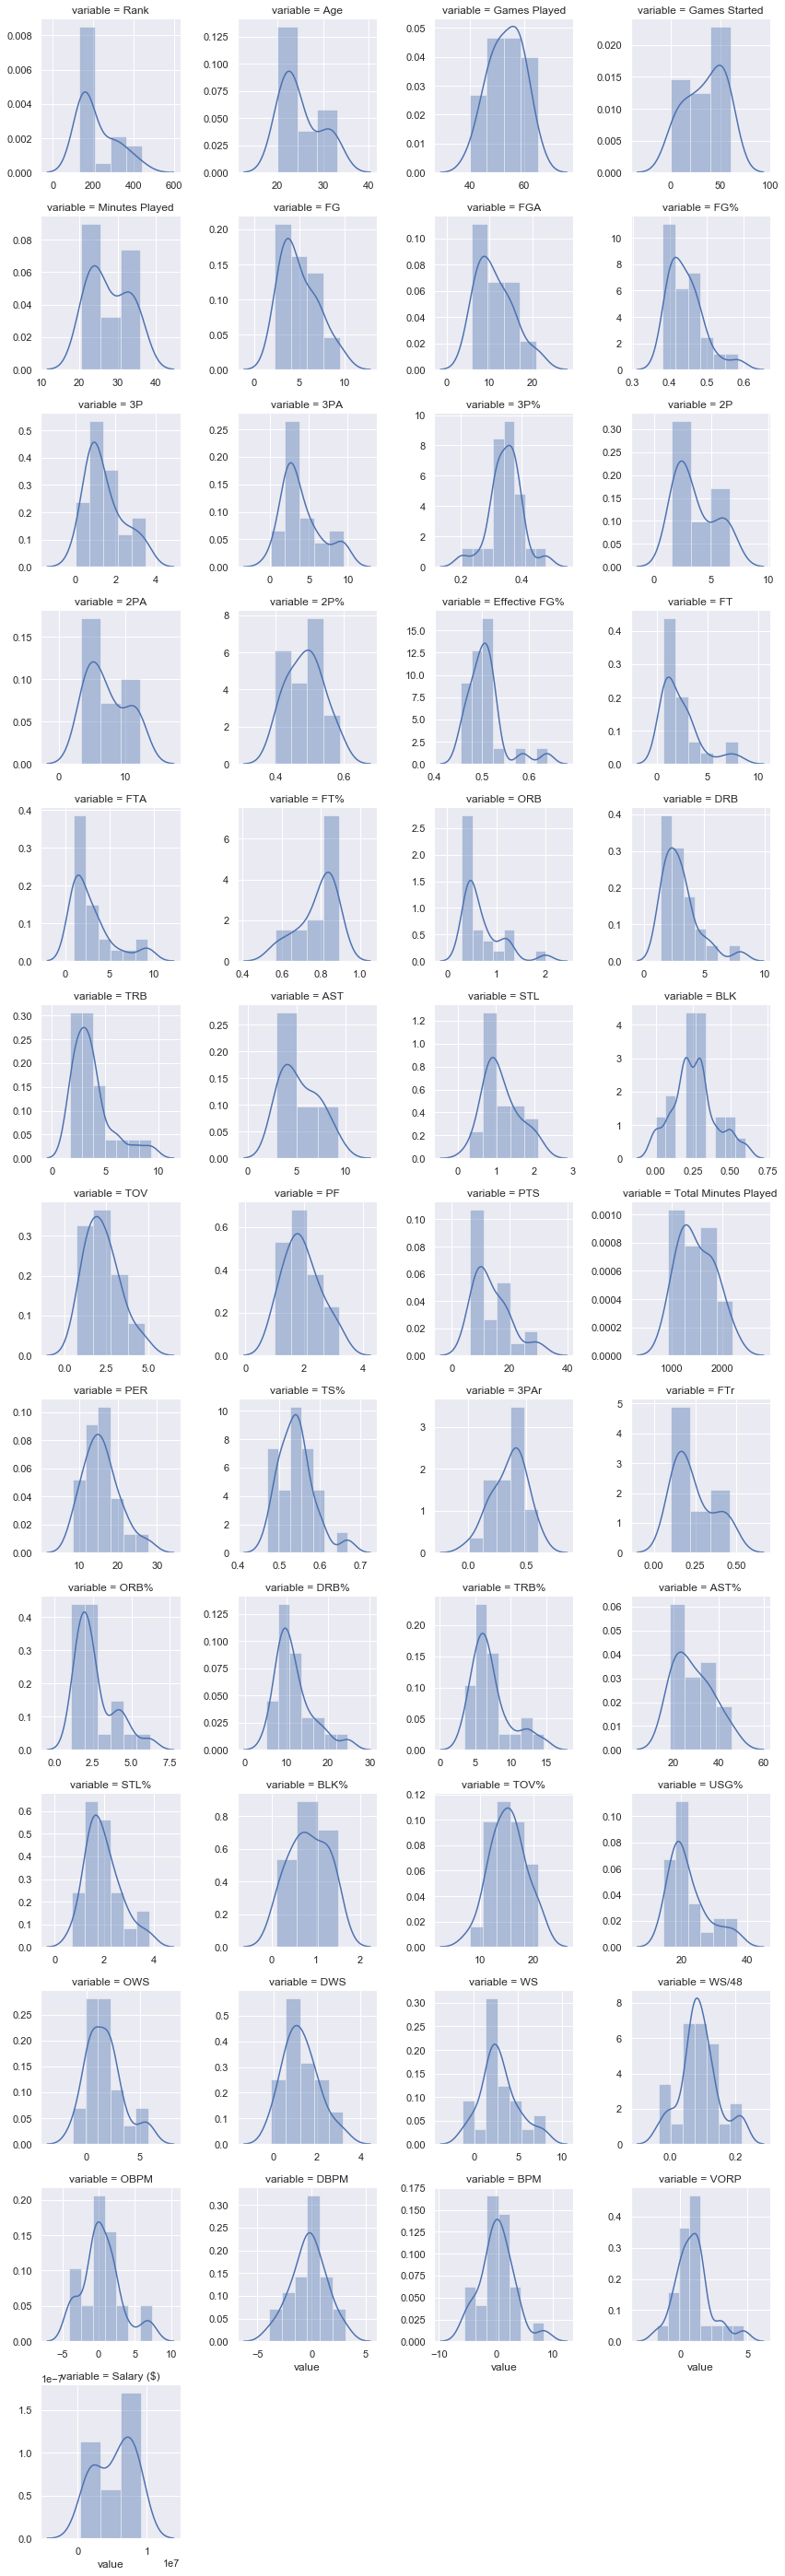

In [99]:
PG_df_num_columns = PG_df.select_dtypes(include=['float64', 'int64']).columns
histograms_numeric_columns(PG_df, PG_df_num_columns)

#### - Shooting Guard (SG):

In [35]:
# Create a new df where we only see SGs
SG_df = all_df.loc[(all_df['Position'] == 'SG')] # select SGs: drops to 115 players
SG_df = SG_df.loc[SG_df['Salary ($)'] <= 7100000] # earns less than ave quota: drops to 79 players
SG_df = SG_df.loc[SG_df['Games Played'] >= 30] # played more than 30 games: drops to 57 players
SG_df = SG_df.loc[SG_df['Minutes Played'] >= 20] # played more than 20 minutes a game: drops to 34 players
SG_df

# Save to CSV:
#SG_df.to_csv('SGs.csv')

,Rank,Player Name,Position,Age,Team,Games Played,Games Started,Minutes Played,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,Effective FG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Total Minutes Played,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Salary ($)
175,176,Jarrett Culver,SG,20,MIN,63,35,23.9,3.7,9.0,0.404,1.0,3.5,0.299,2.6,5.5,0.471,0.462,0.9,1.9,0.462,1.1,2.3,3.4,1.7,0.9,0.6,1.3,2.0,9.2,1506,9.6,0.467,0.388,0.206,4.7,10.3,7.4,10.8,1.8,2.1,11.5,19.2,-1.2,1.1,-0.1,-0.004,-3.2,-0.8,-4.0,-0.8,5813640
182,183,Coby White,SG,19,CHI,65,1,25.8,4.8,12.2,0.394,2.0,5.8,0.354,2.8,6.4,0.430,0.478,1.6,2.0,0.791,0.4,3.1,3.5,2.7,0.8,0.1,1.7,1.8,13.2,1674,11.9,0.506,0.475,0.163,1.8,14.0,7.6,16.5,1.4,0.3,11.4,24.4,-0.4,1.4,0.9,0.026,-1.2,-1.6,-2.8,-0.3,5307120
188,189,Buddy Hield,SG,27,SAC,64,44,32.0,7.1,16.6,0.429,3.8,9.7,0.395,3.3,6.9,0.477,0.544,1.8,2.0,0.855,0.9,3.9,4.8,3.1,0.9,0.3,2.3,2.3,19.8,2045,16.3,0.566,0.582,0.123,3.1,14.1,8.4,15.8,1.4,0.8,11.8,27.1,1.6,1.5,3.1,0.074,2.6,-1.3,1.4,1.7,4861208
190,191,Avery Bradley,SG,29,LAL,49,44,24.2,3.5,7.8,0.444,1.3,3.5,0.364,2.2,4.3,0.510,0.526,0.4,0.5,0.833,0.4,2.0,2.3,1.3,0.9,0.1,1.0,2.2,8.6,1186,8.9,0.537,0.452,0.063,1.7,8.7,5.3,7.1,1.7,0.4,10.7,15.7,0.2,1.4,1.6,0.066,-2.9,0.5,-2.4,-0.1,4767000
193,194,Justin Holiday,SG,30,IND,65,2,24.9,2.9,6.6,0.440,1.9,4.4,0.424,1.0,2.2,0.472,0.581,0.7,0.9,0.780,0.5,2.7,3.2,1.3,1.2,0.6,0.6,1.8,8.4,1617,12.7,0.598,0.667,0.137,2.1,11.9,7.0,7.1,2.3,2.3,8.0,13.5,1.7,2.2,4.0,0.117,0.0,1.7,1.6,1.5,4767000
199,200,Garrett Temple,SG,33,BRK,55,31,28.1,3.6,9.5,0.378,2.0,6.3,0.324,1.6,3.2,0.483,0.485,1.0,1.3,0.767,0.5,2.9,3.5,2.6,0.8,0.5,1.0,1.7,10.3,1547,10.3,0.507,0.660,0.139,1.9,10.5,6.3,13.1,1.3,1.4,9.3,16.6,0.5,1.6,2.1,0.065,-1.5,0.4,-1.1,0.4,4767000
200,201,Collin Sexton,SG,21,CLE,65,65,33.0,7.9,16.7,0.472,1.5,3.9,0.380,6.4,12.8,0.501,0.517,3.5,4.1,0.846,0.9,2.2,3.1,3.0,1.0,0.1,2.4,2.2,20.8,2143,16.3,0.560,0.235,0.246,3.1,7.5,5.3,15.1,1.5,0.3,11.6,27.2,2.2,0.3,2.5,0.057,0.3,-2.1,-1.8,0.1,4764960
212,213,Malik Monk,SG,21,CHO,55,1,21.3,3.9,8.9,0.434,1.1,3.7,0.284,2.8,5.2,0.542,0.494,1.5,1.8,0.820,0.5,2.4,2.9,2.1,0.5,0.3,1.4,1.3,10.3,1169,12.7,0.530,0.418,0.205,2.4,12.6,7.3,16.6,1.1,1.3,12.6,22.9,0.1,0.6,0.7,0.028,-1.0,-1.3,-2.3,-0.1,4028400
217,218,Shai Gilgeous-Alexander,SG,21,OKC,63,63,35.1,7.0,14.8,0.473,1.2,3.5,0.351,5.8,11.3,0.511,0.514,4.0,5.0,0.801,0.7,5.4,6.1,3.3,1.1,0.7,1.9,1.7,19.3,2214,17.8,0.566,0.237,0.339,2.3,16.4,9.6,14.8,1.5,1.7,9.8,23.7,2.9,2.6,5.5,0.120,1.4,0.2,1.6,2.0,3952920
223,224,Tyler Herro,SG,20,MIA,47,6,27.2,4.7,11.3,0.414,2.1,5.4,0.391,2.6,5.9,0.434,0.507,1.4,1.7,0.835,0.3,3.7,4.0,1.9,0.6,0.1,1.5,1.3,12.9,1280,11.4,0.534,0.476,0.148,1.3,14.6,8.2,11.1,1.1,0.5,11.3,22.0,-0.3,1.1,0.9,0.033,-1.0,-1.3,-2.3,-0.1,3640200


#### - Small Forward (SF):

In [36]:
# Create a new df where we only see SFs
SF_df = all_df.loc[(all_df['Position'] == 'SF')] # select SFs: drops to 81 players
SF_df = SF_df.loc[SF_df['Salary ($)'] <= 8000000] # earns less than ave quota: drops to 62 players
SF_df = SF_df.loc[SF_df['Games Played'] >= 30] # played more than 30 games: drops to 41 players
SF_df = SF_df.loc[SF_df['Minutes Played'] >= 20] # played more than 20 minutes a game: drops to 21 players
SF_df

# Save to CSV:
#SF_df.to_csv('SFs.csv')

,Rank,Player Name,Position,Age,Team,Games Played,Games Started,Minutes Played,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,Effective FG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Total Minutes Played,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Salary ($)
149,150,Jae Crowder,SF,29,TOT,58,46,29.2,3.4,8.8,0.384,1.9,6.1,0.318,1.4,2.7,0.532,0.494,1.6,2.1,0.785,0.8,5.3,6.1,2.6,1.2,0.4,1.1,2.2,10.4,1695,12.1,0.532,0.692,0.236,3.1,18.7,11.1,11.7,1.9,1.1,9.9,15.6,1.2,2.0,3.2,0.090,-0.9,0.3,-0.6,0.6,7815533
152,153,Joe Harris,SF,28,BRK,63,63,30.9,5.3,11.2,0.471,2.4,5.9,0.412,2.9,5.3,0.536,0.579,1.0,1.3,0.747,1.0,3.4,4.3,2.1,0.6,0.3,1.5,2.2,13.9,1946,12.7,0.592,0.523,0.118,3.3,10.9,7.2,10.3,0.9,0.7,11.1,17.9,2.1,1.7,3.8,0.094,0.0,-0.5,-0.5,0.8,7670000
159,160,De'Andre Hunter,SF,22,ATL,63,62,32.0,4.4,10.8,0.410,1.7,4.8,0.355,2.7,6.0,0.454,0.489,1.7,2.3,0.764,0.7,3.8,4.5,1.8,0.7,0.3,1.6,2.9,12.3,2018,8.6,0.521,0.445,0.211,2.3,13.1,7.6,8.0,1.0,0.7,12.1,17.5,-0.4,0.5,0.1,0.001,-2.8,-1.8,-4.7,-1.4,7068360
166,167,Jaylen Brown,SF,23,BOS,50,50,34.0,7.6,15.4,0.490,2.1,5.6,0.381,5.4,9.8,0.552,0.559,3.2,4.3,0.736,1.1,5.3,6.4,2.2,1.1,0.3,2.3,3.0,20.4,1702,17.1,0.589,0.364,0.280,3.4,16.5,10.0,10.2,1.6,0.9,11.8,24.7,2.1,2.3,4.5,0.126,1.0,-0.1,0.9,1.2,6534829
176,177,Jonathan Isaac,SF,22,ORL,32,32,29.7,4.7,10.1,0.463,0.9,2.8,0.330,3.7,7.2,0.515,0.509,1.8,2.3,0.767,1.8,5.2,6.9,1.4,1.6,2.4,1.5,2.5,12.0,949,16.9,0.542,0.283,0.227,6.2,19.3,12.6,7.0,2.6,7.4,11.7,18.3,0.4,1.9,2.3,0.114,-0.8,2.9,2.0,1.0,5806440
207,208,Cam Reddish,SF,20,ATL,58,34,26.7,3.7,9.6,0.384,1.4,4.3,0.332,2.2,5.2,0.428,0.459,1.7,2.2,0.802,0.6,3.1,3.7,1.5,1.1,0.5,1.7,2.3,10.5,1551,9.0,0.500,0.451,0.227,2.4,12.7,7.5,8.0,1.9,1.5,13.6,18.9,-1.2,0.8,-0.4,-0.011,-3.2,-1.0,-4.2,-0.9,4245720
209,210,Mikal Bridges,SF,23,PHO,65,24,27.3,3.2,6.3,0.516,0.9,2.4,0.352,2.4,3.8,0.621,0.585,1.4,1.6,0.848,0.9,3.1,4.0,1.8,1.4,0.6,1.0,2.2,8.7,1772,13.0,0.623,0.391,0.258,3.6,12.8,8.1,8.9,2.5,1.9,12.5,12.4,2.2,1.9,4.1,0.111,-0.7,1.5,0.8,1.3,4161000
215,216,Patrick McCaw,SF,24,TOR,37,12,24.5,1.8,4.4,0.414,0.6,1.9,0.324,1.2,2.5,0.484,0.485,0.4,0.5,0.722,0.5,1.8,2.3,2.1,1.1,0.1,0.8,1.6,4.6,908,7.3,0.500,0.438,0.111,2.3,7.6,5.0,11.4,2.0,0.4,14.6,9.4,0.2,1.2,1.4,0.073,-3.6,1.8,-1.8,0.0,4000000
221,222,Miles Bridges,SF,21,CHO,65,64,30.7,4.9,11.6,0.424,1.5,4.6,0.330,3.4,7.0,0.486,0.489,1.6,2.0,0.809,1.4,4.2,5.6,1.8,0.6,0.7,1.5,2.0,13.0,1995,12.1,0.520,0.398,0.174,4.6,15.6,9.9,9.4,1.0,2.2,10.5,20.0,0.3,1.3,1.6,0.038,-1.5,-1.0,-2.5,-0.3,3755400
230,231,Danuel House,SF,26,HOU,58,47,30.0,3.6,8.3,0.427,1.9,5.4,0.363,1.6,2.9,0.544,0.545,1.2,1.5,0.800,1.0,3.3,4.2,1.3,1.1,0.6,0.8,2.1,10.2,1739,11.4,0.571,0.645,0.176,3.4,11.5,7.4,6.1,1.7,1.6,8.6,13.5,1.9,1.6,3.5,0.096,-0.6,0.1,-0.5,0.7,3540000


#### - Power Forward (PF):

In [37]:
# Create a new df where we only see PFs
PF_df = all_df.loc[(all_df['Position'] == 'PF')] # select PFs: drops to 92 players
PF_df = PF_df.loc[PF_df['Salary ($)'] <= 6600000] # earns less than ave quota: drops to 61 players
PF_df = PF_df.loc[PF_df['Games Played'] >= 30] # played more than 30 games: drops to 42 players
PF_df = PF_df.loc[PF_df['Minutes Played'] >= 20] # played more than 20 minutes a game: drops to 21 players
PF_df

# Save to CSV:
#PF_df.to_csv('PFs.csv')

,Rank,Player Name,Position,Age,Team,Games Played,Games Started,Minutes Played,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,Effective FG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Total Minutes Played,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Salary ($)
167,168,Jabari Parker,PF,24,TOT,33,23,25.8,6.0,12.1,0.499,0.9,3.5,0.267,5.1,8.6,0.594,0.538,1.7,2.2,0.743,1.6,4.3,5.9,1.8,1.3,0.5,1.8,2.8,14.7,852,17.0,0.561,0.291,0.185,6.7,18.1,12.3,11.7,2.3,1.5,12.2,24.0,0.5,0.7,1.2,0.066,0.2,-0.4,-0.1,0.4,6500000
179,180,Trey Lyles,PF,24,SAS,63,53,20.2,2.4,5.4,0.446,1.0,2.7,0.387,1.4,2.8,0.503,0.541,0.5,0.7,0.733,1.1,4.6,5.7,1.1,0.4,0.4,0.6,1.6,6.4,1271,12.7,0.557,0.490,0.131,6.0,24.6,15.3,7.3,1.1,1.9,9.7,13.7,1.2,1.0,2.2,0.081,-0.5,-0.7,-1.2,0.2,5500000
183,184,Lauri Markkanen,PF,22,CHI,50,50,29.8,5.0,11.8,0.425,2.2,6.3,0.344,2.8,5.5,0.518,0.517,2.5,3.1,0.824,1.2,5.1,6.3,1.5,0.8,0.5,1.6,1.9,14.7,1492,14.3,0.560,0.536,0.259,4.2,19.7,11.6,7.6,1.4,1.5,11.0,21.1,1.1,1.6,2.6,0.084,0.2,-0.8,-0.5,0.5,5300400
192,193,JaMychal Green,PF,29,LAC,55,0,20.5,2.3,5.5,0.414,1.3,3.7,0.363,0.9,1.8,0.520,0.536,0.6,0.8,0.727,1.4,5.0,6.3,0.8,0.5,0.4,0.8,2.7,6.5,1130,10.8,0.554,0.675,0.146,7.0,24.3,15.9,5.1,1.0,1.6,12.3,13.5,0.8,1.8,2.6,0.111,-1.4,0.6,-0.8,0.3,4767000
202,203,Rui Hachimura,PF,21,WAS,41,41,29.7,5.3,11.1,0.478,0.5,1.8,0.274,4.8,9.3,0.517,0.500,2.2,2.7,0.829,1.5,4.5,6.0,1.7,0.8,0.2,1.0,2.2,13.4,1217,13.9,0.543,0.160,0.243,5.5,17.4,11.2,8.3,1.3,0.5,7.5,18.7,1.3,0.4,1.7,0.066,-1.1,-1.9,-3.0,-0.3,4469160
211,212,Cameron Johnson,PF,23,PHO,49,1,20.3,2.8,6.6,0.418,1.9,4.7,0.397,0.9,2.0,0.469,0.558,0.7,0.9,0.761,0.8,2.1,2.9,1.1,0.6,0.3,0.6,1.5,8.1,996,12.2,0.576,0.705,0.142,4.3,11.5,7.8,7.4,1.4,1.4,7.7,16.0,1.1,0.7,1.8,0.086,0.5,-0.7,-0.2,0.5,4033440
214,215,Dorian Finney-Smith,PF,26,DAL,64,61,29.7,3.3,7.1,0.468,1.5,4.1,0.374,1.8,3.0,0.599,0.577,1.1,1.5,0.722,2.0,3.5,5.5,1.5,0.7,0.6,1.0,2.4,9.3,1898,12.2,0.597,0.580,0.212,7.0,12.3,9.7,6.8,1.1,1.7,11.2,12.7,2.9,1.6,4.5,0.114,0.0,-0.1,-0.2,0.9,4000000
219,220,P.J. Washington,PF,21,CHO,58,57,30.3,4.6,10.2,0.455,1.5,4.0,0.374,3.1,6.2,0.507,0.528,1.5,2.3,0.647,1.0,4.4,5.4,2.1,0.9,0.8,1.6,2.7,12.2,1759,12.4,0.547,0.390,0.231,3.5,16.6,9.8,11.3,1.5,2.3,12.5,18.6,0.5,1.4,2.0,0.054,-1.7,0.1,-1.6,0.2,3831840
234,235,Dario Šarić,PF,25,PHO,58,50,24.8,3.7,8.1,0.462,1.3,3.7,0.341,2.5,4.4,0.563,0.539,1.4,1.6,0.832,1.5,4.4,5.9,1.9,0.6,0.3,1.2,2.3,10.1,1441,13.3,0.572,0.455,0.202,6.7,20.2,13.3,10.9,1.1,0.9,12.3,17.2,1.5,1.2,2.7,0.091,-0.5,-0.4,-0.9,0.4,3481986
237,238,Bam Adebayo,PF,22,MIA,65,65,34.4,6.3,11.1,0.567,0.0,0.2,0.077,6.3,10.9,0.576,0.568,3.6,5.3,0.690,2.5,8.0,10.5,5.1,1.2,1.3,2.8,2.5,16.2,2235,20.6,0.606,0.018,0.476,8.7,25.0,17.2,23.6,1.7,3.8,17.5,20.8,4.6,3.6,8.1,0.175,1.6,2.1,3.6,3.2,3454080


#### - Center (C):

In [38]:
# Create a new df where we only see Cs
C_df = all_df.loc[(all_df['Position'] == 'C')] # select Cs: drops to 87 players
C_df = C_df.loc[C_df['Salary ($)'] <= 6600000] # earns less than ave quota: drops to 52 players
C_df = C_df.loc[C_df['Games Played'] >= 30] # played more than 30 games: drops to 36 players
C_df = C_df.loc[C_df['Minutes Played'] >= 20] # played more than 20 minutes a game: drops to 10 players
C_df

# Save to CSV:
#C_df.to_csv('Cs.csv')

,Rank,Player Name,Position,Age,Team,Games Played,Games Started,Minutes Played,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,Effective FG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Total Minutes Played,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Salary ($)
172,173,Montrezl Harrell,C,26,LAC,63,2,27.8,7.5,12.9,0.580,0.0,0.3,0.000,7.5,12.6,0.593,0.580,3.7,5.6,0.658,2.6,4.5,7.1,1.7,0.6,1.1,1.7,2.3,18.6,1749,23.1,0.607,0.022,0.432,9.9,16.2,13.1,10.3,1.1,3.6,10.1,25.5,4.5,2.5,7.0,0.193,2.4,0.5,2.9,2.2,6000000
180,181,Aron Baynes,C,33,PHO,42,28,22.2,4.4,9.1,0.480,1.4,4.0,0.351,3.0,5.1,0.582,0.558,1.3,1.8,0.747,1.7,4.0,5.6,1.6,0.2,0.5,1.2,3.4,11.5,934,15.1,0.581,0.441,0.197,8.3,20.2,14.1,11.0,0.5,2.2,10.8,21.1,1.3,0.7,2.0,0.103,-0.2,-0.9,-1.1,0.2,5453280
185,186,Wendell Carter Jr.,C,20,CHI,43,43,29.2,4.3,8.0,0.534,0.1,0.7,0.207,4.1,7.3,0.564,0.542,2.6,3.5,0.737,3.2,6.2,9.4,1.2,0.8,0.8,1.7,3.8,11.3,1256,15.5,0.590,0.085,0.443,11.6,24.6,17.8,6.0,1.3,2.7,14.9,16.4,1.7,1.6,3.3,0.127,-2.1,-0.3,-2.4,-0.1,5201400
186,187,Daniel Theis,C,27,BOS,58,57,23.8,3.7,6.6,0.565,0.4,1.4,0.321,3.3,5.2,0.631,0.599,1.4,1.8,0.764,2.2,4.3,6.6,1.6,0.6,1.3,0.8,3.5,9.3,1382,18.2,0.629,0.212,0.277,10.2,19.2,14.7,9.9,1.2,5.0,10.1,14.7,3.6,2.3,5.9,0.205,0.4,1.8,2.3,1.5,5000000
194,195,Richaun Holmes,C,26,SAC,39,33,28.8,5.4,8.2,0.654,0.0,0.0,NaN,5.4,8.2,0.654,0.654,2.1,2.6,0.800,3.0,5.3,8.3,1.0,1.0,1.4,1.3,3.9,12.8,1125,20.5,0.685,0.000,0.312,11.5,21.3,16.3,5.4,1.7,4.7,11.8,16.0,3.2,1.5,4.6,0.198,0.6,0.9,1.5,1.0,4767000
195,196,Frank Kaminsky,C,26,PHO,32,13,22.4,4.0,8.7,0.455,1.2,3.5,0.348,2.8,5.2,0.527,0.525,1.8,2.8,0.670,0.9,4.0,4.9,2.2,0.4,0.3,1.0,2.2,11.0,718,14.5,0.554,0.401,0.315,4.6,20.2,12.2,14.8,0.9,1.2,9.4,20.8,0.8,0.6,1.4,0.092,0.2,-0.3,-0.1,0.3,4767000
231,232,Domantas Sabonis,C,23,IND,62,62,34.8,7.4,13.7,0.540,0.3,1.1,0.254,7.1,12.6,0.565,0.550,3.5,4.8,0.723,3.0,9.4,12.4,5.0,0.8,0.5,2.7,3.1,18.5,2159,20.7,0.586,0.079,0.349,9.7,29.5,19.7,21.7,1.1,1.2,14.8,23.4,4.2,3.3,7.6,0.168,2.1,1.1,3.2,2.9,3529555
287,288,Jarrett Allen,C,21,BRK,64,58,25.7,4.2,6.5,0.646,0.0,0.1,0.000,4.2,6.4,0.654,0.646,2.3,3.7,0.620,3.0,6.4,9.5,1.3,0.6,1.3,1.1,2.3,10.6,1647,20.3,0.658,0.012,0.574,12.5,25.0,18.9,7.8,1.1,4.3,12.2,15.0,4.3,2.8,7.1,0.207,1.0,1.1,2.1,1.7,2376840
303,304,Willie Cauley-Stein,C,26,TOT,54,39,20.3,3.2,5.6,0.579,0.0,0.0,0.000,3.2,5.6,0.581,0.579,0.7,1.2,0.606,1.6,4.3,5.8,1.3,0.9,1.1,0.7,2.2,7.2,1097,17.0,0.589,0.003,0.219,8.0,23.2,15.5,9.9,2.1,4.9,10.8,14.4,1.5,1.5,3.0,0.129,-1.2,1.7,0.5,0.7,2177483
369,370,Mitchell Robinson,C,21,NYK,61,7,23.1,4.1,5.6,0.742,0.0,0.0,NaN,4.1,5.6,0.742,0.742,1.4,2.4,0.568,3.0,4.0,7.0,0.6,0.9,2.0,0.6,3.2,9.7,1412,23.5,0.726,0.000,0.434,13.7,18.8,16.2,3.9,1.8,8.0,8.3,13.3,4.8,2.0,6.8,0.230,1.6,1.3,3.0,1.8,1559712


We selected our cheap starting five team (the DagZ Devils) consisting of:

- PG) Luka Donçić
- SG) Shai Gilgeous-Alexander
- SF) OG Anunoby
- PF) Pascal Siakam
- C) Domantas Sabonis

Now, traditional basketball experts will say that running a triangle offense is the best way to go in order to win. A research paper written at Arizona State University (*referenced by Wired's article at the end of this Notebook*) also explains why this is true with their mathematical modeling focusing only on the ball. But how do we predict in our case if these five people will succeed together in winning using analytics? There are two ways to go about this:
1) We can look at each player's data and forecast how they could do.
2) We can forecast by creating a chemistry factor between the team members to assess how good they will get along considering their stats already show they are effective players.

Basketball stats are not linear and regular regressions have been proven by many sports analyst experts that they don't work. In our case, we will apply some other models:

## Conclusion:

We made our cheap starting five team (the DagZ Devils) consisting of:

- PG) Luka Donçić
- SG) Shai Gilgeous-Alexander
- SF) OG Anunoby
- PF) Pascal Siakam
- C) Domantas Sabonis

Using the following model(s), we predicted our team to:
- 
- 
- 



There are many other projects involving NBA analytics trying to replicate similar things to what were done by Daryl Morey, Bill James, Billy Beane and many others. On top of that, there are also many papers (even conferences) trying to observe the different aspects and statistics involved trying to understand correlations between different variables. An example is how the salaries are related to the players' performance and which statistics have the most impact on their salaries. Ever since the NBA adopted using a state of the art video system to track the players and the ball movement on the court, it allowed them to collect extremely high amounts of new data which in term allowed data scientists to use machine learning and cartography to better assess which players helped their team to win, guide the GMs, coaches and so on. On top of that, NBA players now have wearable technologies to track their health, avoid injury and track their fatigue levels. In this era of technology, analytics can arguably go to unprecedented levels within basketball. Personally, I think it is going a bit too far. The fact is no matter how hard you analyze, your result will never be 100% certain nor will it be 100% of the solution, it should only support a better percentage in decision making. In the end, the game's outcome is in the hands of the athletes.

## References + Articles:

Here are some of the references and articles used in this project linked below for those interested in basketball analytics:

[The Economist - How data transformed the NBA (Video)](https://www.youtube.com/watch?v=oUvvfHkXyOA&list=WL&index=5&t=1s)

[60 Minutes - Basketball Analytics (Video)](https://www.youtube.com/watch?v=BHuZc9lQ5ss)

[HBS - Moreyball: The Houston Rockets & Analytics](https://digital.hbs.edu/platform-digit/submission/moreyball-the-houston-rockets-and-analytics/)

[Bleacher Report - NBA Sabermetrics Team in 2011](https://bleacherreport.com/articles/771677-nba-sabermetrics-the-ultimate-moneyball-team)

[Bleacher Report - Understanding the NBA: Explaining Advanced Comprehensive Stats and Metrics](https://bleacherreport.com/articles/1040320-understanding-the-nba-explaining-advanced-comprehensive-stats-and-metrics)

[Wired - Basketball Isn’t a Sport. It’s a Statistical Network](https://www.wired.com/2012/12/basketball-network-analysis/)

[Washington Post - How data geeks are taking over basketball](https://www.washingtonpost.com/news/book-party/wp/2016/03/18/how-data-geeks-are-taking-over-basketball/)

[Samford University - An Analysis of NBA Teams Spending by Position for the Upcoming Season](https://www.samford.edu/sports-analytics/fans/2019/An-Analysis-of-NBA-Teams-Spending-by-Position-for-the-Upcoming-Season)

[The Sports Journal - NBA Players’ Pay and Performance: What Counts?](https://thesportjournal.org/article/nba-players-pay-and-performance-what-counts/)

[Wikipedia - Advanced Statistics](https://en.wikipedia.org/wiki/Advanced_statistics_in_basketball)

[Basketball Reference - Explaining Win Shares](https://www.basketball-reference.com/about/ws.html)

[Sports Reference - Explaining Win Shares](https://www.sports-reference.com/cbb/about/ws.html)

[Reddit - Explaining Win Shares](https://www.reddit.com/r/nba/comments/2bv4cp/stats_101_win_shares/)

[Michael Lewis - The Undoing Project](www.google.com)

[Michael Lewis - The No-Stats All-Star Shane Battier](https://www.nytimes.com/2009/02/15/magazine/15Battier-t.html)